### Data Prep

<Axes: xlabel='time'>

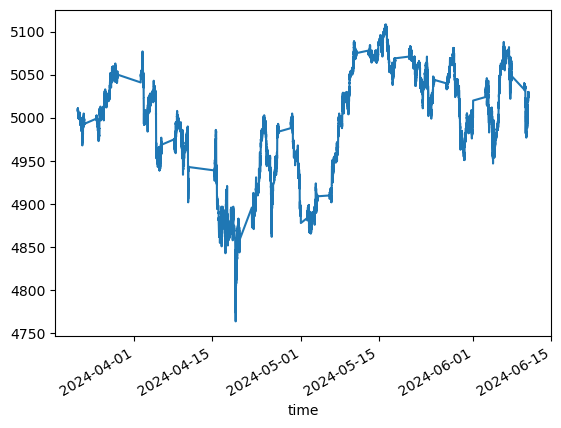

In [1]:
import pandas as pd
import numpy as np

df=pd.read_csv("FSX5E_20240101_1_20240611.csv").dropna()
df.index=pd.to_datetime(df["time"])
df=df.drop(columns=["time"])
df.close.plot()

In [2]:
from sklearn.model_selection import train_test_split

train_p1, test_p2 = train_test_split(df, test_size=0.2, shuffle=False)
train_p1, train_p2 = train_test_split(train_p1, test_size=0.7, shuffle=False)

<Axes: xlabel='time'>

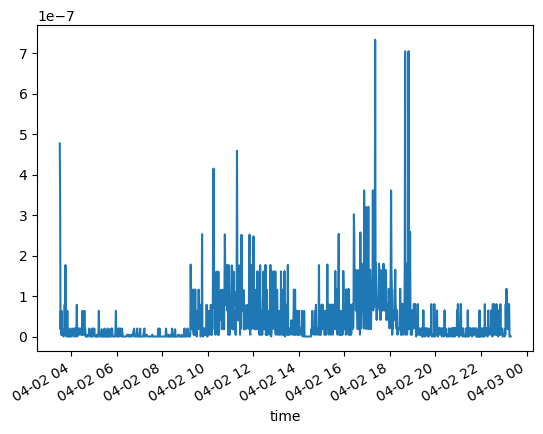

In [3]:
train_p1['vol']=0.5*(np.log(train_p1.high/train_p1.low)**2)-(2*np.log(2)-1)*(np.log(train_p1.close/train_p1.open)**2)
train_p1['vol'].loc['2024-04-02'].plot()

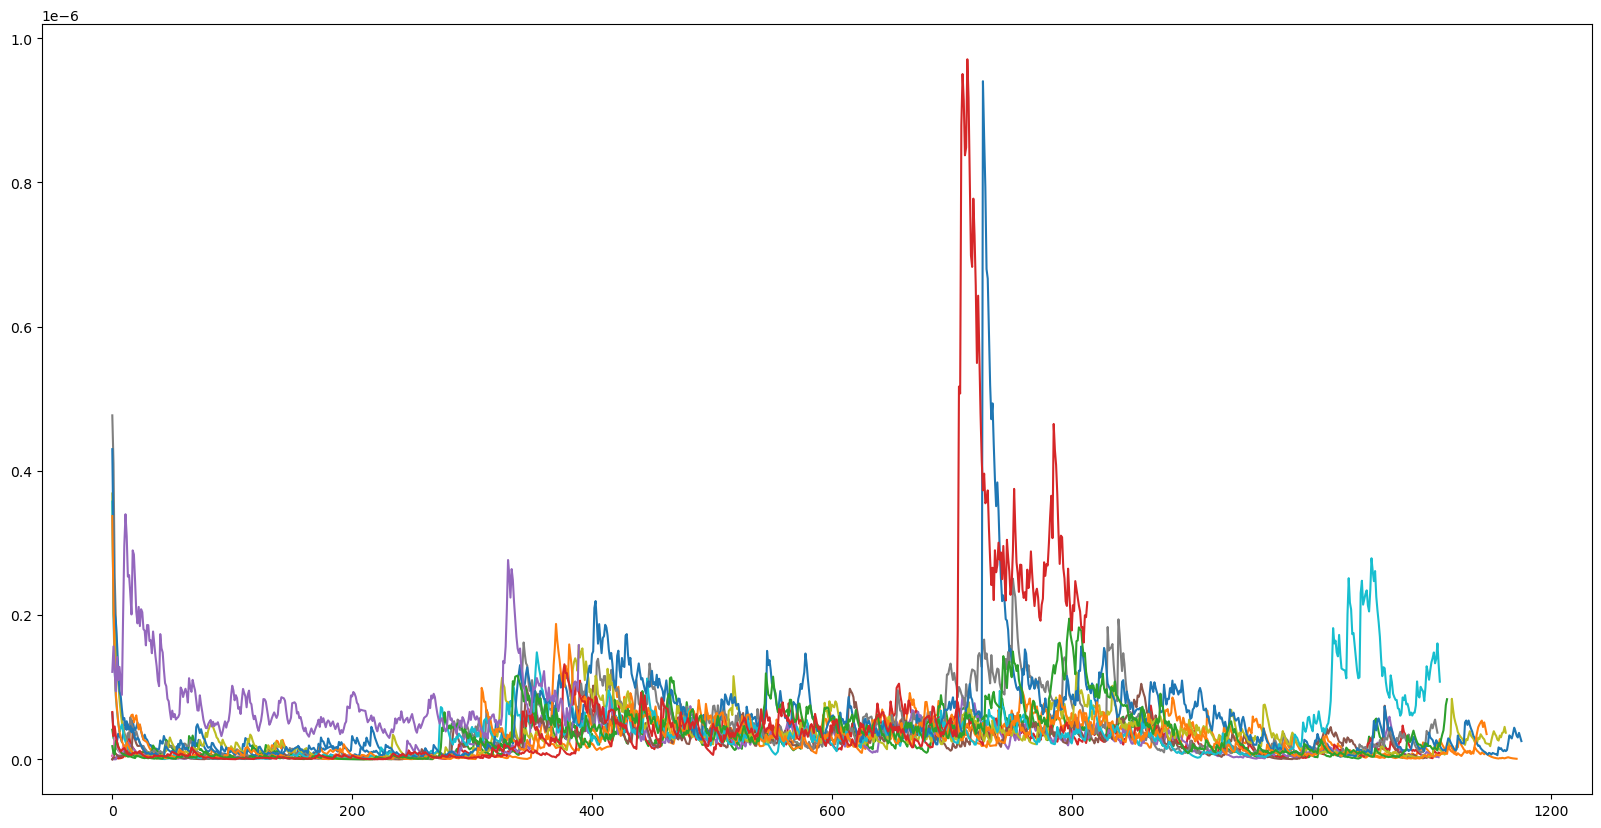

In [4]:
for day in train_p1.index.normalize().unique():
    day_str=str(day).split(" ")[0]
    train_p1['vol'].loc[day_str].ewm(span=10).mean().reset_index(drop=True).plot(figsize=(20,10))   



In [5]:
train_p1['vol'].sort_values(ascending=False).head(10)

time
2024-04-05 15:45:00    4.905063e-06
2024-04-10 15:47:00    2.552665e-06
2024-04-10 15:45:00    2.032923e-06
2024-04-10 15:52:00    1.521186e-06
2024-04-10 15:48:00    1.270709e-06
2024-04-10 15:57:00    1.203566e-06
2024-04-10 17:04:00    1.177773e-06
2024-04-10 16:01:00    1.062843e-06
2024-04-10 15:51:00    8.974320e-07
2024-04-10 15:44:00    8.484977e-07
Name: vol, dtype: float64

<Axes: >

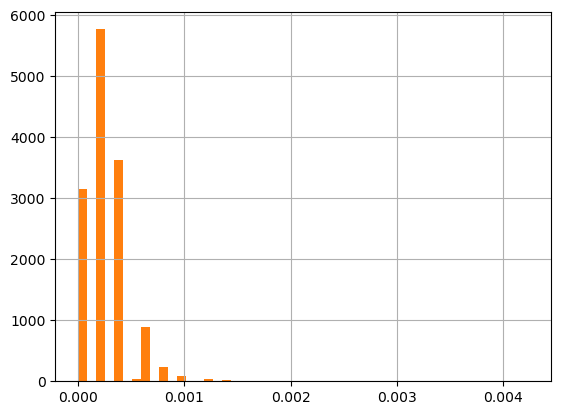

In [6]:
ranges=np.abs(train_p1.high/train_p1.low-1)
ranges.hist(bins=100)
ranges[ranges<0.005].hist(bins=50)

<Axes: xlabel='time'>

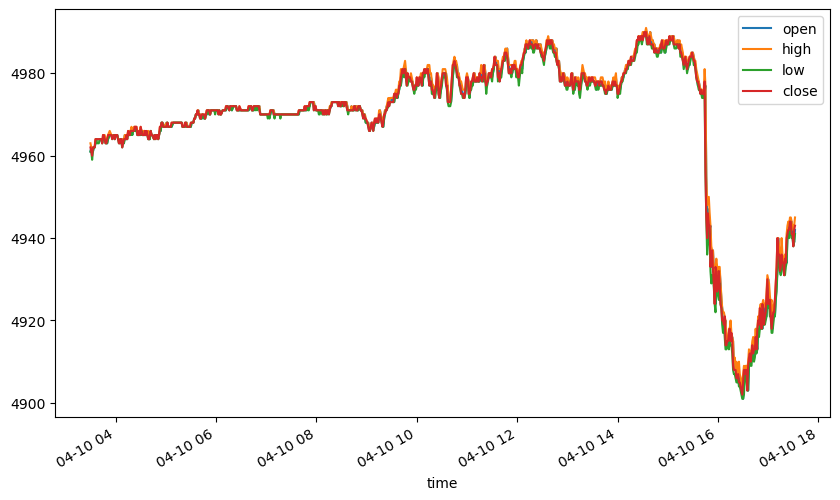

In [7]:
day=train_p1['vol'].sort_values(ascending=False).head(10).index.normalize().unique()[1].strftime("%Y-%m-%d")    

train_p1.loc[day,["open","high","low","close"]].plot(figsize=(10,6))
#train_p1.loc[day,"vol"].plot(secondary_y=True,figsize=(10,6)) 

<Axes: xlabel='time'>

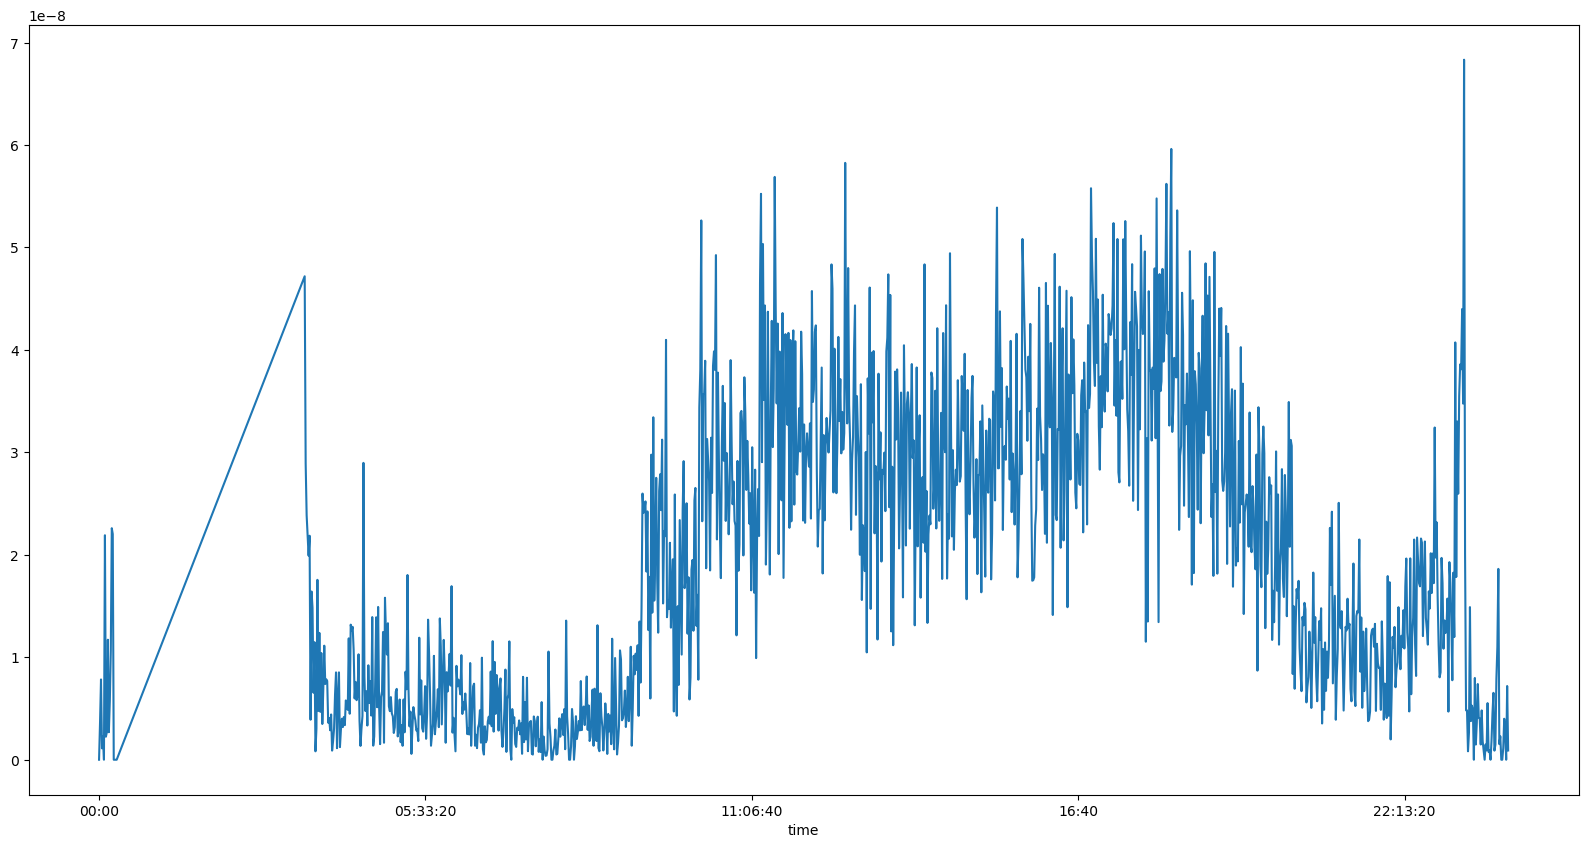

In [8]:
qtl=0.9
train_p1.loc[train_p1.vol<train_p1.vol.quantile(qtl),'vol'].groupby(train_p1.loc[train_p1.vol<train_p1.vol.quantile(qtl)].index.time).mean().plot(figsize=(20,10))    

### Outlier Detection

<Axes: >

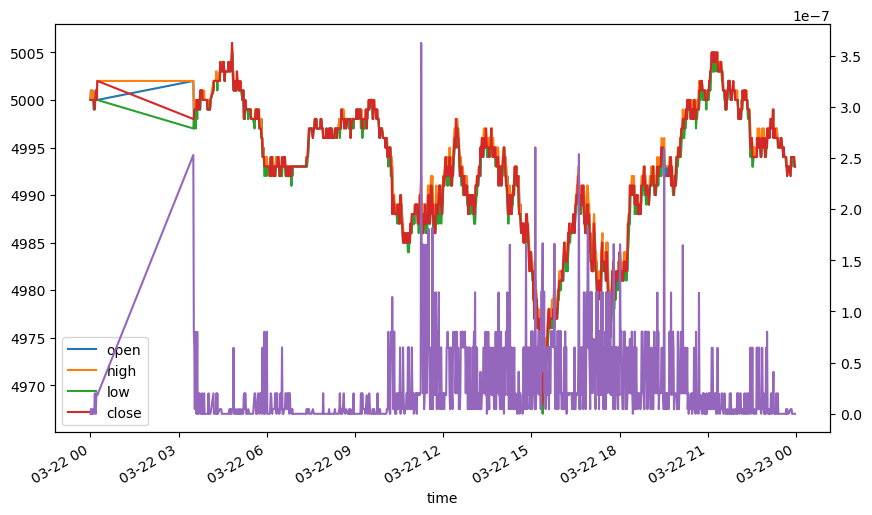

In [9]:
#removing the outliers
qtl=0.995
X_p1_d=train_p1.loc[train_p1.vol<train_p1.vol.quantile(qtl),['vol','volume']]
train_p1_d=train_p1.loc[train_p1.vol<train_p1.vol.quantile(qtl)]


day=train_p1_d['vol'].sort_values(ascending=False).head(20).index.normalize().unique()[6].strftime("%Y-%m-%d")    

train_p1_d.loc[day,["open","high","low","close"]].plot(figsize=(10,6))
train_p1_d.loc[day,"vol"].plot(secondary_y=True,figsize=(10,6)) 

In [10]:
X_p1=X_p1_d
train_p1=train_p1_d

<Axes: xlabel='time'>

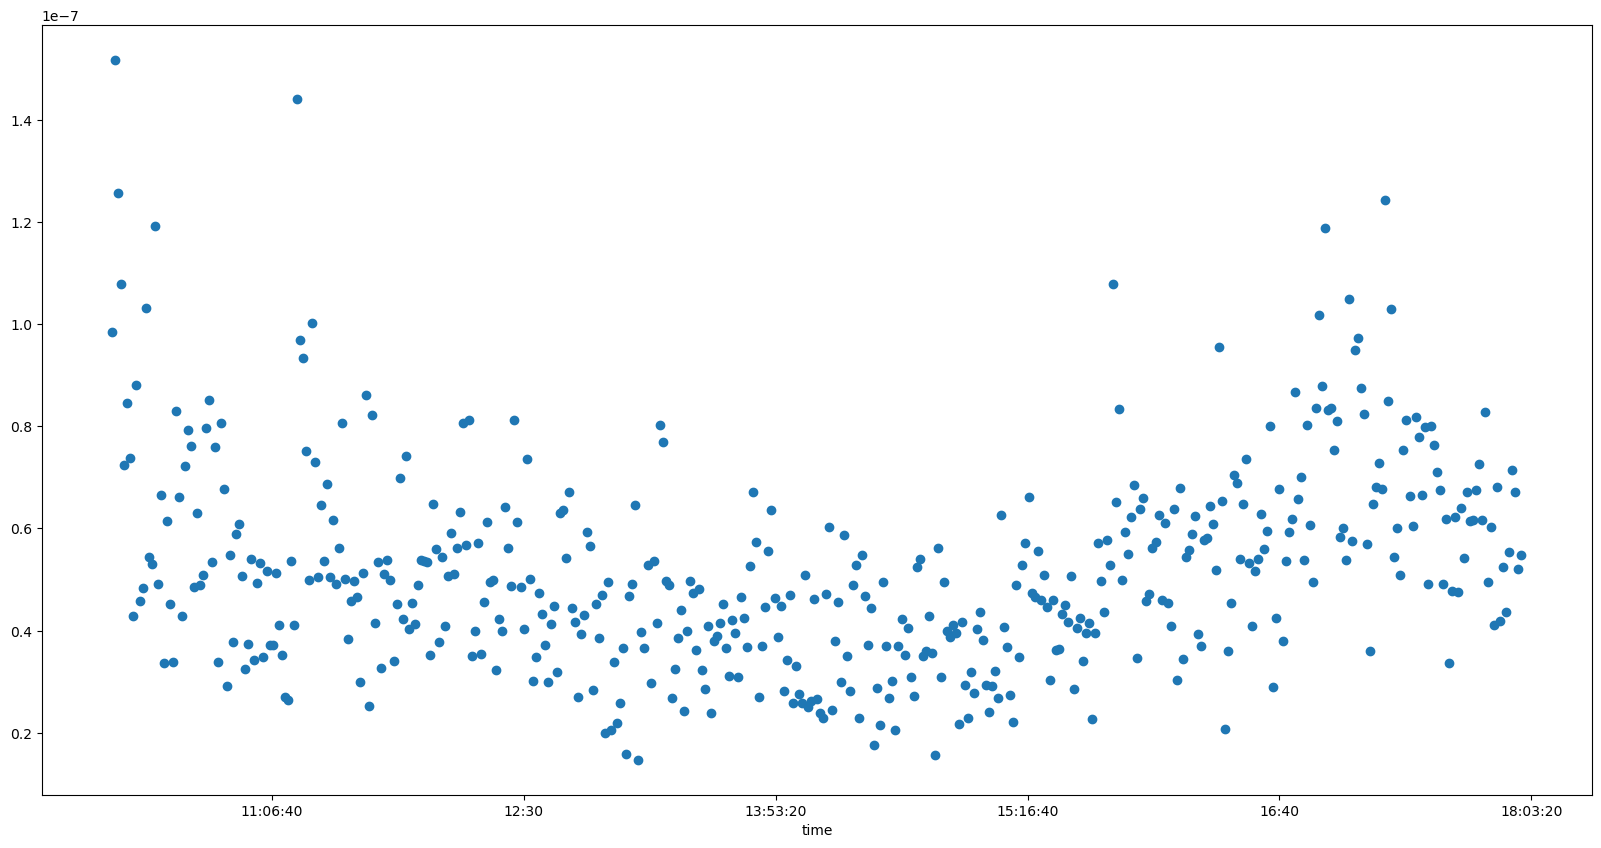

In [11]:
start_hour="10:14"
end_hour="18:00"
X_p1.vol.between_time(start_hour,end_hour).groupby(X_p1.vol.between_time(start_hour,end_hour).index.time).mean().plot(style="o",figsize=(20,10))


In [12]:
X_p1=X_p1_d.between_time(start_hour, end_hour)
train_p1=train_p1_d.between_time(start_hour, end_hour)


### Seasonal Models

Training fold 1...
Validation MSE for fold 1: 0.012154234573245049
Training fold 2...
Validation MSE for fold 2: 0.016129380092024803
Training fold 3...
Validation MSE for fold 3: 0.013006060384213924
Training fold 4...
Validation MSE for fold 4: 0.02120666392147541
Training fold 5...
Validation MSE for fold 5: 0.014010545797646046
Average Validation MSE: 0.015301376953721047
Epoch 1/100
47/47 [==============================] - 1s 2ms/step - loss: 0.0449
Epoch 2/100
47/47 [==============================] - 0s 2ms/step - loss: 0.0222
Epoch 3/100
47/47 [==============================] - 0s 2ms/step - loss: 0.0212
Epoch 4/100
47/47 [==============================] - 0s 2ms/step - loss: 0.0204
Epoch 5/100
47/47 [==============================] - 0s 2ms/step - loss: 0.0195
Epoch 6/100
47/47 [==============================] - 0s 2ms/step - loss: 0.0194
Epoch 7/100
47/47 [==============================] - 0s 2ms/step - loss: 0.0189
Epoch 8/100
47/47 [==============================] - 0s 2ms/s

<Axes: xlabel='time'>

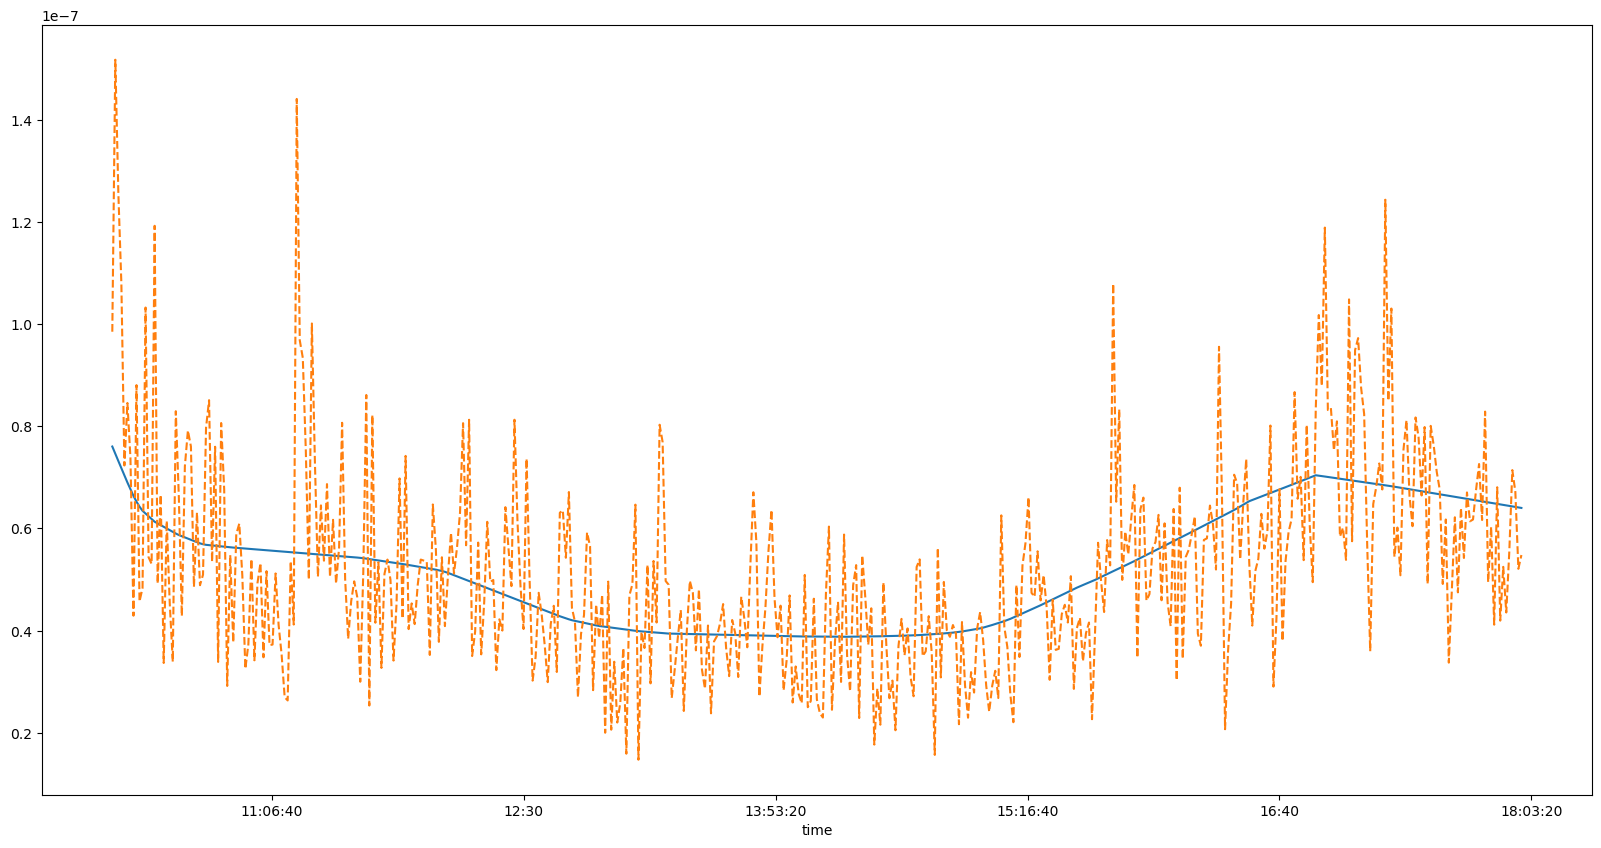

In [13]:


import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold

seasonal = X_p1.groupby(X_p1.index.time).vol.mean()
time_p = pd.Series(np.arange(len(seasonal)) / len(seasonal), index=seasonal.index)

X = time_p.values.reshape(-1, 1)  # Reshape for a single feature input
y = seasonal.values.reshape(-1, 1)  # Reshape for compatibility with scaler

# Normalize the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_normalized = scaler_X.fit_transform(X)
y_normalized = scaler_y.fit_transform(y)

# Define a function to create the MLP model with more layers and dropout
def create_model():
    model = Sequential()
    model.add(Dense(128, input_dim=1, activation='relu')) 
    model.add(Dropout(0.2))  
    model.add(Dense(64, activation='relu'))  
    model.add(Dropout(0.2))  
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1))  
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
mse_scores = []

for train_index, val_index in kf.split(X_normalized):
    print(f'Training fold {fold_no}...')
    
    # Split data into training and validation sets
    X_train, X_val = X_normalized[train_index], X_normalized[val_index]
    y_train, y_val = y_normalized[train_index], y_normalized[val_index]
    
    model = create_model()
    
    model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)
    
    # Evaluate the model on the validation set
    val_mse = model.evaluate(X_val, y_val, verbose=0)
    mse_scores.append(val_mse)
    print(f'Validation MSE for fold {fold_no}: {val_mse}')
    
    fold_no += 1
average_mse = np.mean(mse_scores)
print(f'Average Validation MSE: {average_mse}')

mlp_seasonal_mod = create_model()
mlp_seasonal_mod.fit(X_normalized, y_normalized, epochs=100, batch_size=10, verbose=1)

predictions_normalized = mlp_seasonal_mod.predict(X_normalized)

seasonal_mlp_preds = scaler_y.inverse_transform(predictions_normalized)
seasonal_mlp_preds = pd.Series(seasonal_mlp_preds.flatten(), index=seasonal.index)


seasonal_mlp_preds.plot(figsize=(20,10))
seasonal.plot(style='--',figsize=(20,10))


In [14]:
import statsmodels.api as sm
X_p1=X_p1.between_time(start_hour,end_hour)
seasonal_vol = X_p1.groupby(X_p1.index.time).vol.mean()
seasonal_time_p = pd.Series(np.arange(len(seasonal_vol)) / len(seasonal_vol), index=seasonal_vol.index)

X_seasonal=sm.add_constant(pd.concat([seasonal_time_p,seasonal_time_p**2,seasonal_time_p**3],axis=1))
seasonal_ols_model=sm.OLS(seasonal_vol,X_seasonal).fit()
seasonal_ols_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    vol   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     57.52
Date:                Wed, 12 Jun 2024   Prob (F-statistic):           1.27e-31
Time:                        17:20:37   Log-Likelihood:                 7689.3
No. Observations:                 467   AIC:                        -1.537e+04
Df Residuals:                     463   BIC:                        -1.535e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        7.75e-08   3.15e-09     24.577      0.000    7.13e-08    8.37e-08
0          -1.972e-07   2.74e-08     -7.199      0.000   -2.51e-07   -1.43e-07
1           3.031e-07   6.38e-08      4.748      0.000    1.78e-07    4.29e-07
2          -1.118e-07   4.21e-08     -2.658      0.008   -1.94e-07   -2.91e-08
==============================================================================
Omnibus:                       83.011   Durbin-Watson:                   1.465
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              177.906
Skew:                           0.948   Prob(JB):                     2.33e-39
Kurtosis:                       5.355   Cond. No.                         124.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<Axes: xlabel='time'>

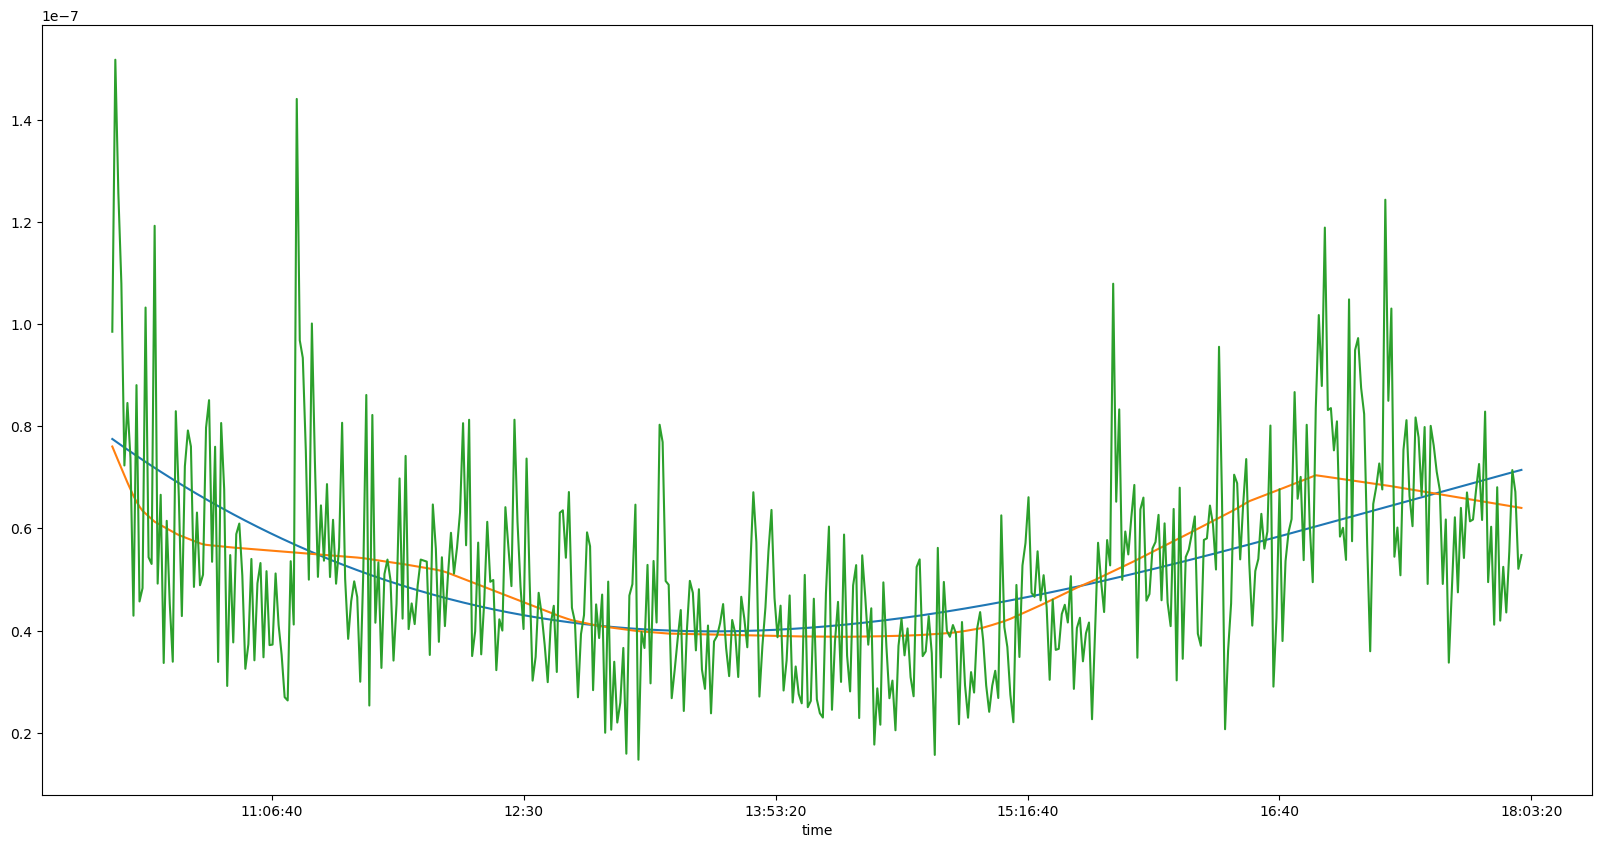

In [15]:
seasonal_vol_ols_preds=seasonal_ols_model.predict(X_seasonal)
seasonal_vol_ols_preds.plot()
seasonal_vol_ml_preds=seasonal_mlp_preds
seasonal_vol_ml_preds.plot()
seasonal_vol.plot(figsize=(20,10))  

<Axes: xlabel='time'>

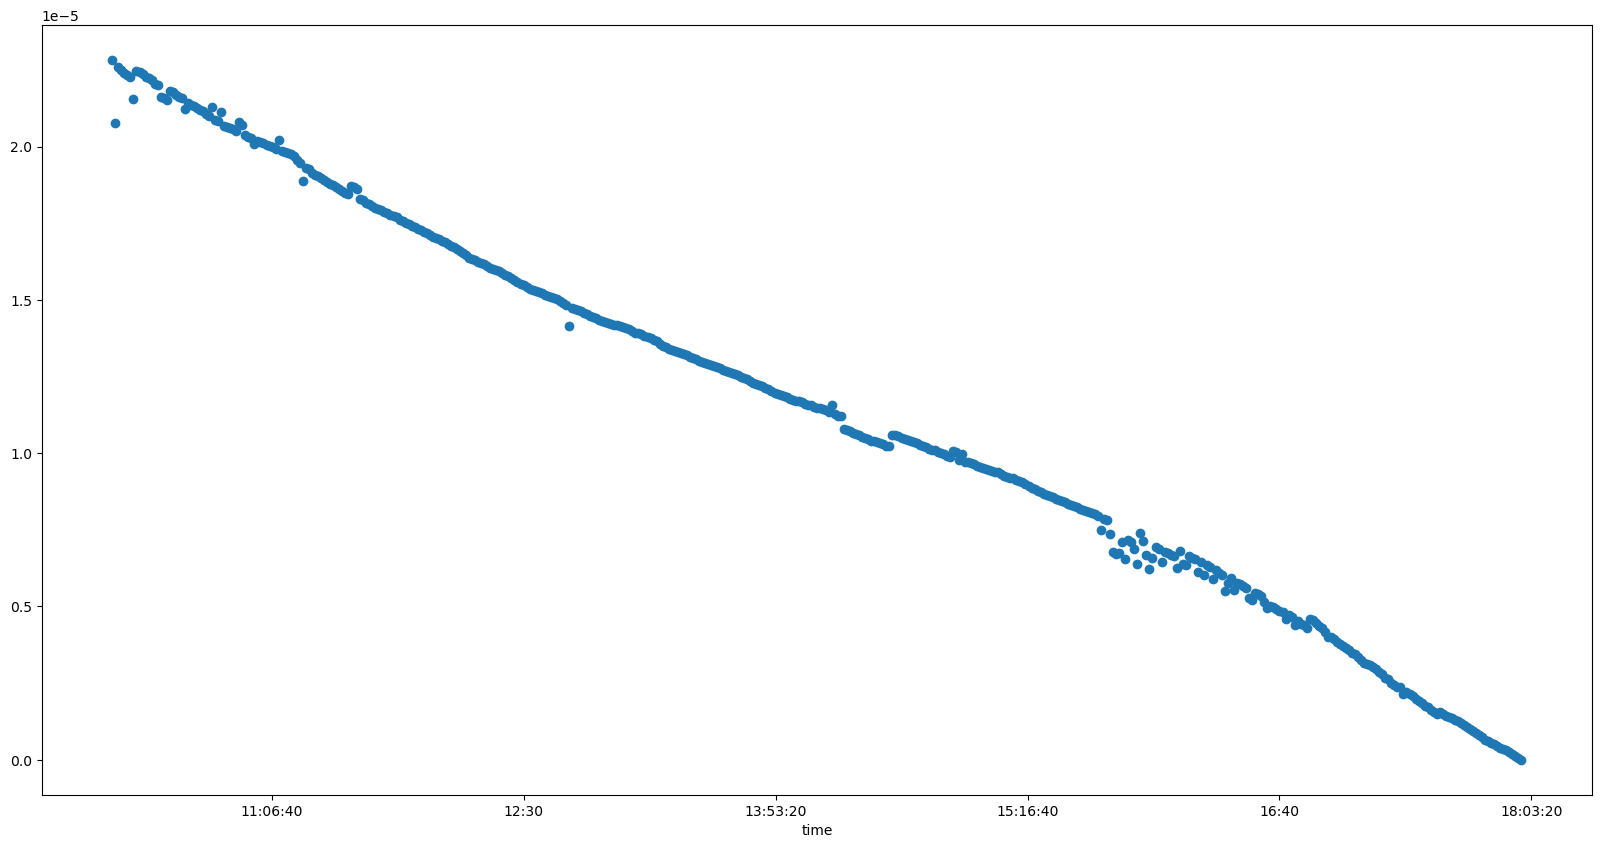

In [16]:
train_p1=train_p1.between_time(start_hour,end_hour)
int_vol_daily=train_p1.groupby(train_p1.index.date).vol.sum()
train_p1['int_vol_eod']=train_p1.index.normalize().map(int_vol_daily)-train_p1.groupby(train_p1.index.normalize()).vol.cumsum()
train_p1['int_vol_eod'].groupby(train_p1.index.time).mean().plot(figsize=(20,10),style="o")

c:\Users\yusuf.bektas\AppData\Local\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='time'>

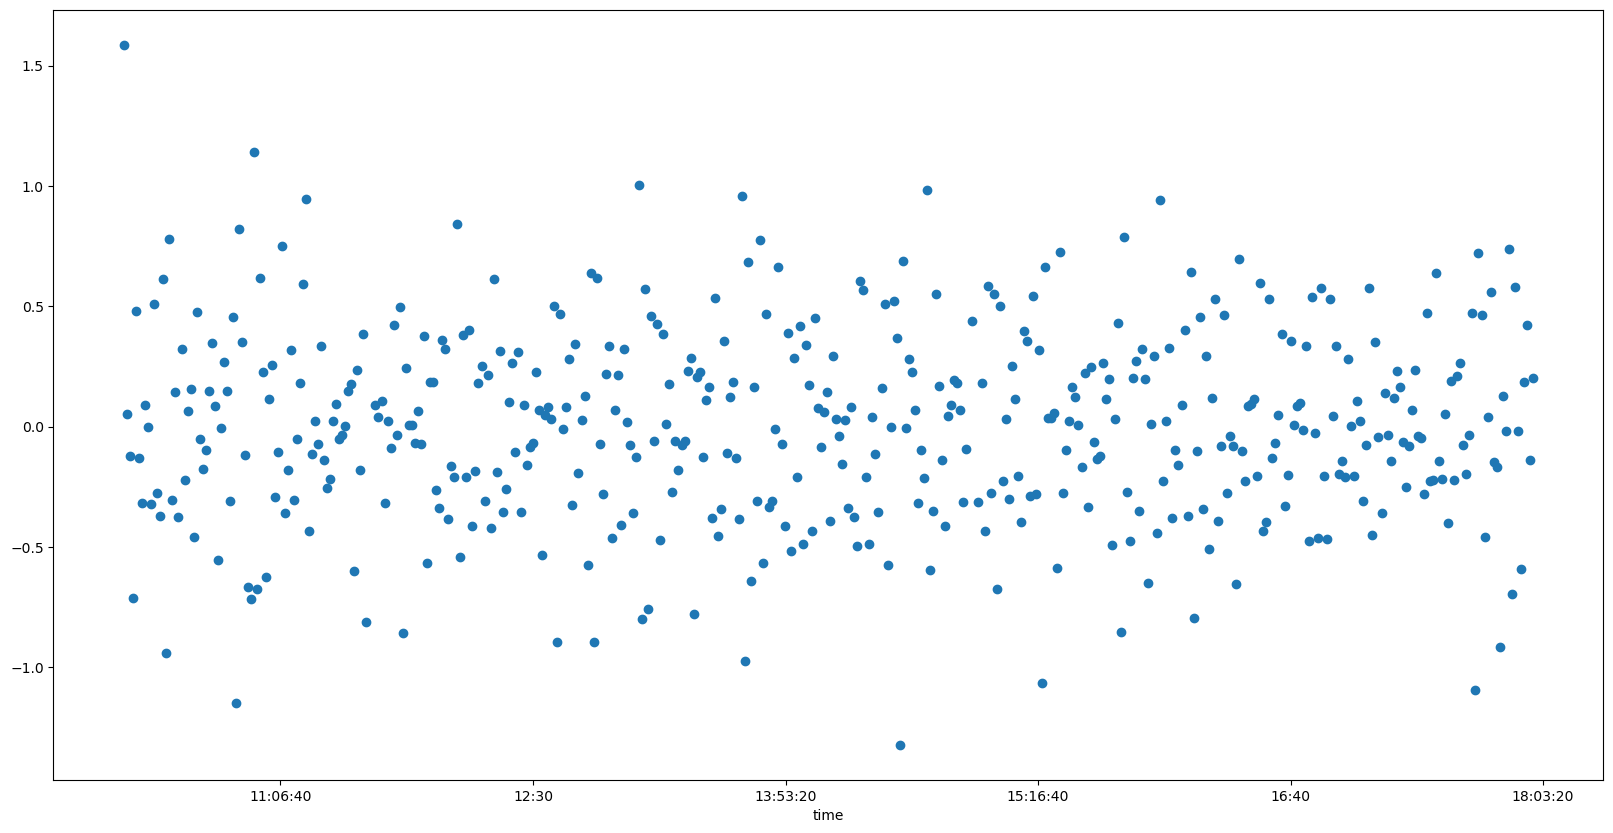

In [17]:
X_p1['volume_log_ret']=np.log(X_p1.volume/X_p1.volume.shift(1)).dropna().between_time("10:15","18:00")
X_p1=X_p1.dropna()
X_p1['volume_log_ret'].groupby(X_p1.index.time).mean().plot(figsize=(20,10),style="o")

In [18]:
train_p2['vol']=0.5*(np.log(train_p2.high/train_p2.low)**2)-(2*np.log(2)-1)*(np.log(train_p2.close/train_p2.open)**2)
train_p2['volume_ret']=np.log(train_p2.volume/train_p2.volume.shift(1))
train_p2=train_p2.dropna().between_time("10:15","18:00")
train_p2

c:\Users\yusuf.bektas\AppData\Local\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,open,high,low,close,volume,vwap,vol,volume_ret
time,,,,,,,,
2024-04-15 16:52:00,4978.0,4982.0,4976.0,4981.0,1879.0,4980.200,5.858731e-07,0.100111
2024-04-15 16:53:00,4982.0,4983.0,4981.0,4983.0,1019.0,4982.239,6.501862e-08,-0.611918
2024-04-15 16:54:00,4983.0,4984.0,4982.0,4982.0,715.0,4982.887,6.498628e-08,-0.354294
2024-04-15 16:55:00,4983.0,4986.0,4983.0,4985.0,1080.0,4984.259,1.189167e-07,0.412434
2024-04-15 16:56:00,4985.0,4985.0,4983.0,4983.0,1079.0,4983.404,1.830990e-08,-0.000926
...,...,...,...,...,...,...,...,...
2024-05-27 17:40:00,5053.0,5054.0,5053.0,5054.0,109.0,5053.037,4.452434e-09,0.820147
2024-05-27 17:41:00,5054.0,5054.0,5053.0,5053.0,552.0,5053.621,4.452434e-09,1.622200
2024-05-27 17:42:00,5052.0,5054.0,5052.0,5054.0,204.0,5053.206,1.781326e-08,-0.995428


<Axes: xlabel='time'>

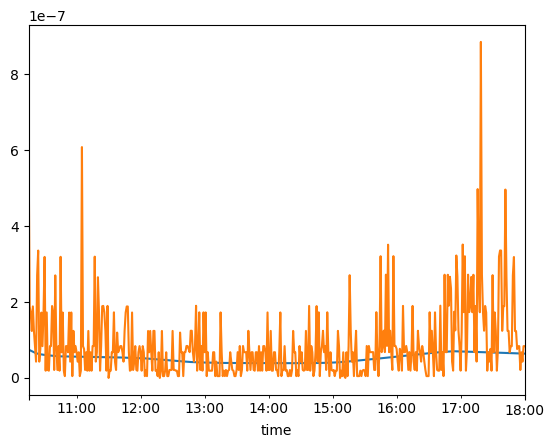

In [19]:
pd.Series(train_p2.index.time,index=train_p2.index).map(seasonal_mlp_preds).loc["2024-04-18"].plot()
train_p2['vol'].loc["2024-04-18"].plot()

<Axes: xlabel='time'>

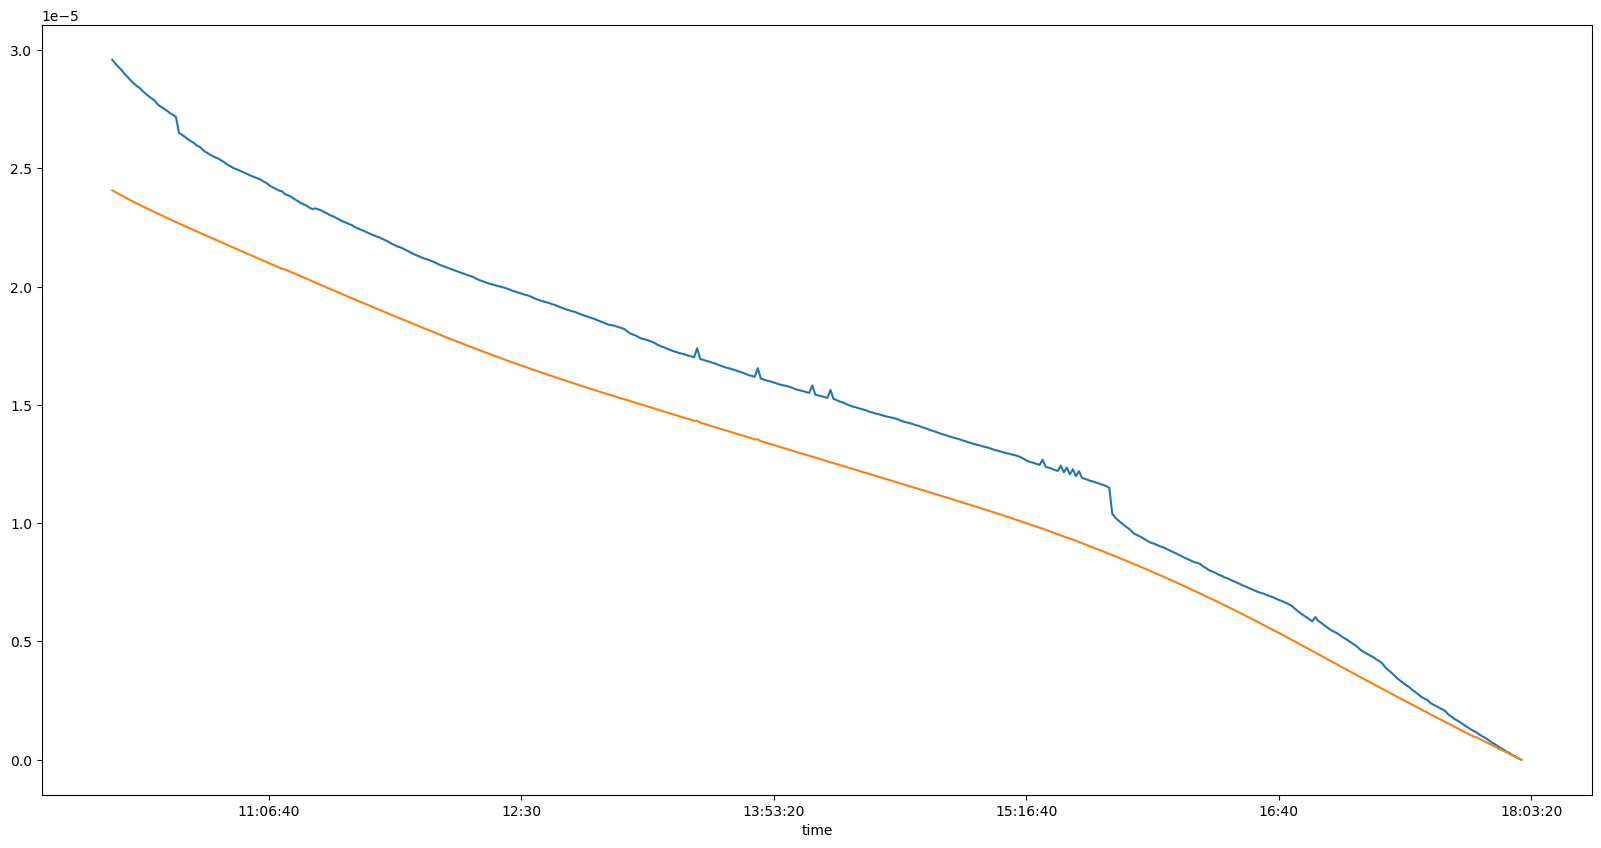

In [20]:
train_p2['seasonal_vol']=pd.Series(train_p2.index.time,index=train_p2.index).map(seasonal_mlp_preds)
cum_vol=train_p2.groupby(train_p2.index.date).vol.cumsum()
eod_cum_vol=cum_vol.groupby(train_p2.index.date).last()
train_p2['int_vol_eod']=train_p2.index.normalize().map(eod_cum_vol)-cum_vol
seasonal_cum_vol=train_p2.groupby(train_p2.index.date).seasonal_vol.cumsum()
eod_seasonal_cum_vol=seasonal_cum_vol.groupby(train_p2.index.date).last()
train_p2['int_seasonal_eod']=train_p2.index.normalize().map(eod_seasonal_cum_vol)-seasonal_cum_vol
train_p2['int_vol_eod'].groupby(train_p2.index.time).mean().plot(figsize=(20,10))
train_p2['int_seasonal_eod'].groupby(train_p2.index.time).mean().plot(figsize=(20,10),)

### Integrated Vol Models

c:\Users\yusuf.bektas\AppData\Local\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\yusuf.bektas\AppData\Local\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


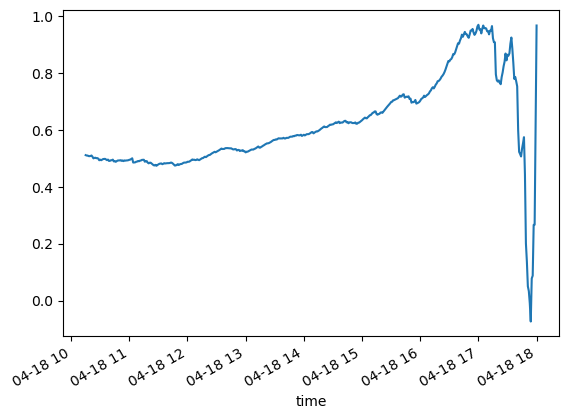

In [21]:
avg_period=10
train_p2['seasonal_diff']=np.log(train_p2['vol']/train_p2['seasonal_vol'])
train_p2['seasonal_diff_avg']=train_p2['seasonal_diff'].rolling(avg_period).mean()
train_p2['time_p']=train_p2.groupby(train_p2.index.normalize()).cumcount()/train_p2.groupby(train_p2.index.normalize()).cumcount().max()
X_p2=train_p2[['volume_ret','seasonal_diff','seasonal_diff_avg','time_p']].replace([np.inf,-np.inf],np.nan).dropna()
y_p2=np.log(train_p2.int_vol_eod/train_p2.int_seasonal_eod).shift(-1).replace([np.inf,-np.inf],np.nan).dropna()
y_p2.loc['2024-04-18'].plot()
common_index=X_p2.index.intersection(y_p2.index)
X_p2=X_p2.loc[common_index]
y_p2=y_p2.loc[common_index]

Epoch 1/1000
165/165 [==============================] - 3s 3ms/step - loss: 0.4547
Epoch 2/1000
165/165 [==============================] - 1s 3ms/step - loss: 0.1272
Epoch 3/1000
165/165 [==============================] - 1s 4ms/step - loss: 0.0714
Epoch 4/1000
165/165 [==============================] - 1s 4ms/step - loss: 0.0551
Epoch 5/1000
165/165 [==============================] - 1s 3ms/step - loss: 0.0458
Epoch 6/1000
165/165 [==============================] - 1s 4ms/step - loss: 0.0385
Epoch 7/1000
165/165 [==============================] - 1s 4ms/step - loss: 0.0324
Epoch 8/1000
165/165 [==============================] - 1s 4ms/step - loss: 0.0290
Epoch 9/1000
165/165 [==============================] - 1s 4ms/step - loss: 0.0249
Epoch 10/1000
165/165 [==============================] - 1s 4ms/step - loss: 0.0219
Epoch 11/1000
165/165 [==============================] - 1s 3ms/step - loss: 0.0204
Epoch 12/1000
165/165 [==============================] - 1s 3ms/step - loss: 0.0179
E

<Axes: xlabel='time'>

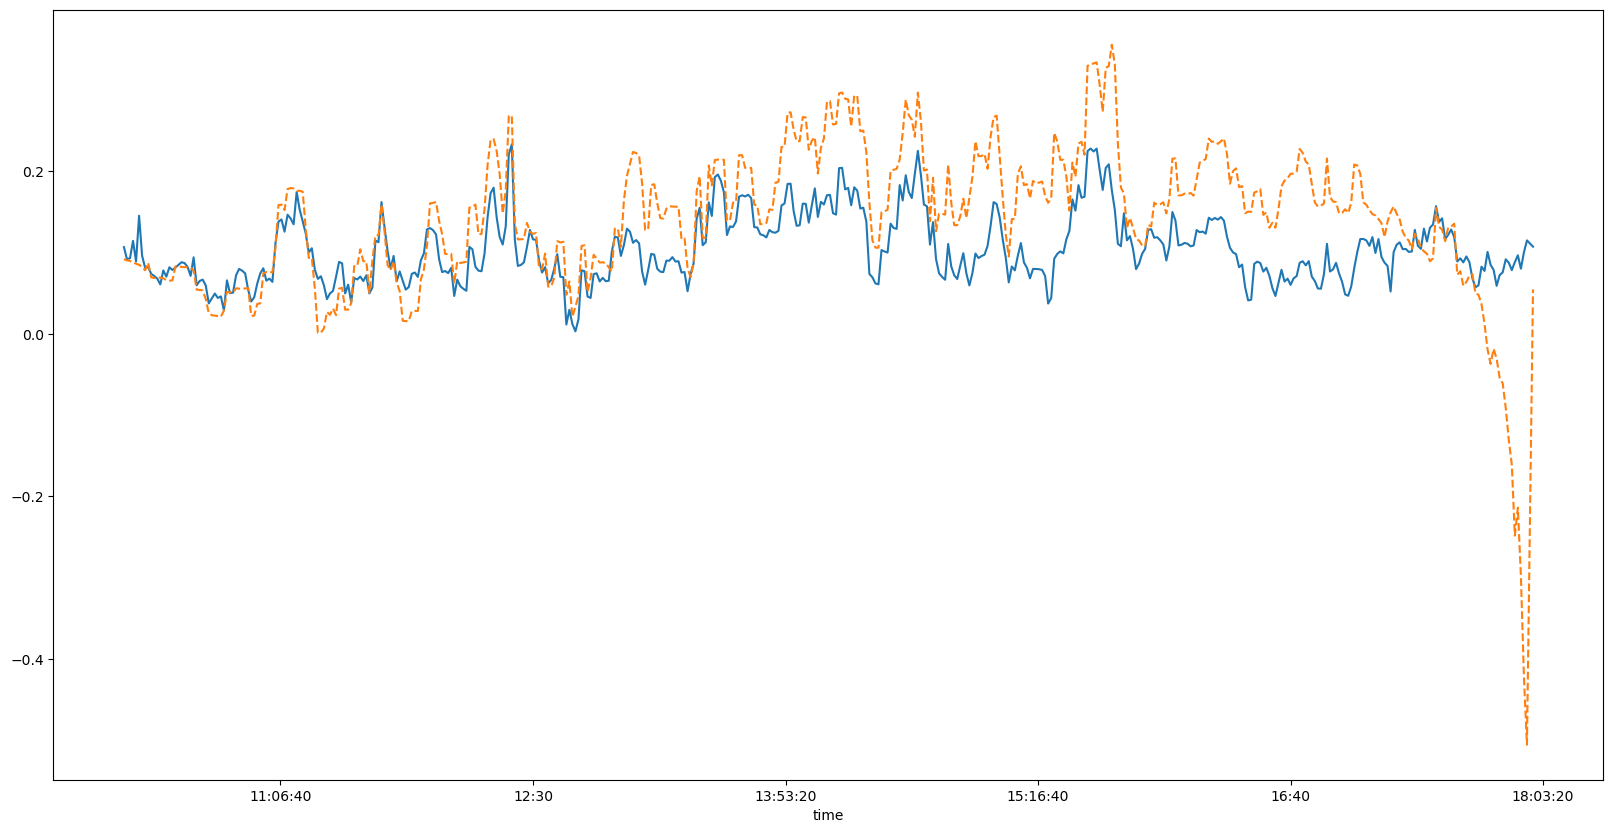

In [126]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold


X = X_p2
y = y_p2

# Normalize the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()


X_normalized = scaler_X.fit_transform(X)
y_normalized = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Define a function to create the MLP model with more layers and dropout
def create_model():
    model = Sequential()
    model.add(Dense(128, input_dim=X.shape[1], activation='relu')) 
    model.add(Dropout(0.2))  
    model.add(Dense(64, activation='relu'))  
    model.add(Dropout(0.2))  
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))  
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))  
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mean_squared_error')
    return model

"""
kf = KFold(n_splits=3, shuffle=True, random_state=42)
fold_no = 1
mse_scores = []

for train_index, val_index in kf.split(X_normalized):
    print(f'Training fold {fold_no}...')
    
    # Split data into training and validation sets
    X_train, X_val = X_normalized[train_index], X_normalized[val_index]
    y_train, y_val = y_normalized[train_index], y_normalized[val_index]
    
    model = create_model()
    
    model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)
    
    # Evaluate the model on the validation set
    val_mse = model.evaluate(X_val, y_val, verbose=0)
    mse_scores.append(val_mse)
    print(f'Validation MSE for fold {fold_no}: {val_mse}')
    
    fold_no += 1
average_mse = np.mean(mse_scores)
print(f'Average Validation MSE: {average_mse}')
"""
mlp_int_vol_mod = create_model()
mlp_int_vol_mod.fit(X_normalized, y_normalized, epochs=1000, batch_size=64, verbose=1)
print("fit complete")
predictions_normalized = mlp_int_vol_mod.predict(X_normalized)

int_vol_mlp_preds = scaler_y.inverse_transform(predictions_normalized)
int_vol_mlp_preds = pd.Series(int_vol_mlp_preds.flatten(), index=y_p2.index)


int_vol_mlp_preds.groupby(y_p2.index.time).mean().plot(figsize=(20,10))
y_p2.groupby(y_p2.index.time).mean().plot(style='--',figsize=(20,10))


In [22]:
ols_int_vol_mod=sm.OLS(y_p2,sm.add_constant(X_p2)).fit()
ols_int_vol_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     1462.
Date:                Wed, 12 Jun 2024   Prob (F-statistic):               0.00
Time:                        17:21:29   Log-Likelihood:                -5859.5
No. Observations:               10537   AIC:                         1.173e+04
Df Residuals:                   10532   BIC:                         1.177e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.2553      0.008     31.441      0.000       0.239       0.271
volume_ret            0.0028      0.004      0.769      0.442      -0.004       0.010
seasonal_diff         0.0081      0.004      2.011      0.044       0.000       0.016
seasonal_diff_avg     0.4649      0.007     63.259      0.000       0.451       0.479
time_p                0.0416      0.014      3.046      0.002       0.015       0.068
==============================================================================
Omnibus:                      219.061   Durbin-Watson:                   0.094
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              481.380
Skew:                           0.019   Prob(JB):                    2.95e-105
Kurtosis:                       4.046   Cond. No.                         5.55
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<Axes: xlabel='time'>

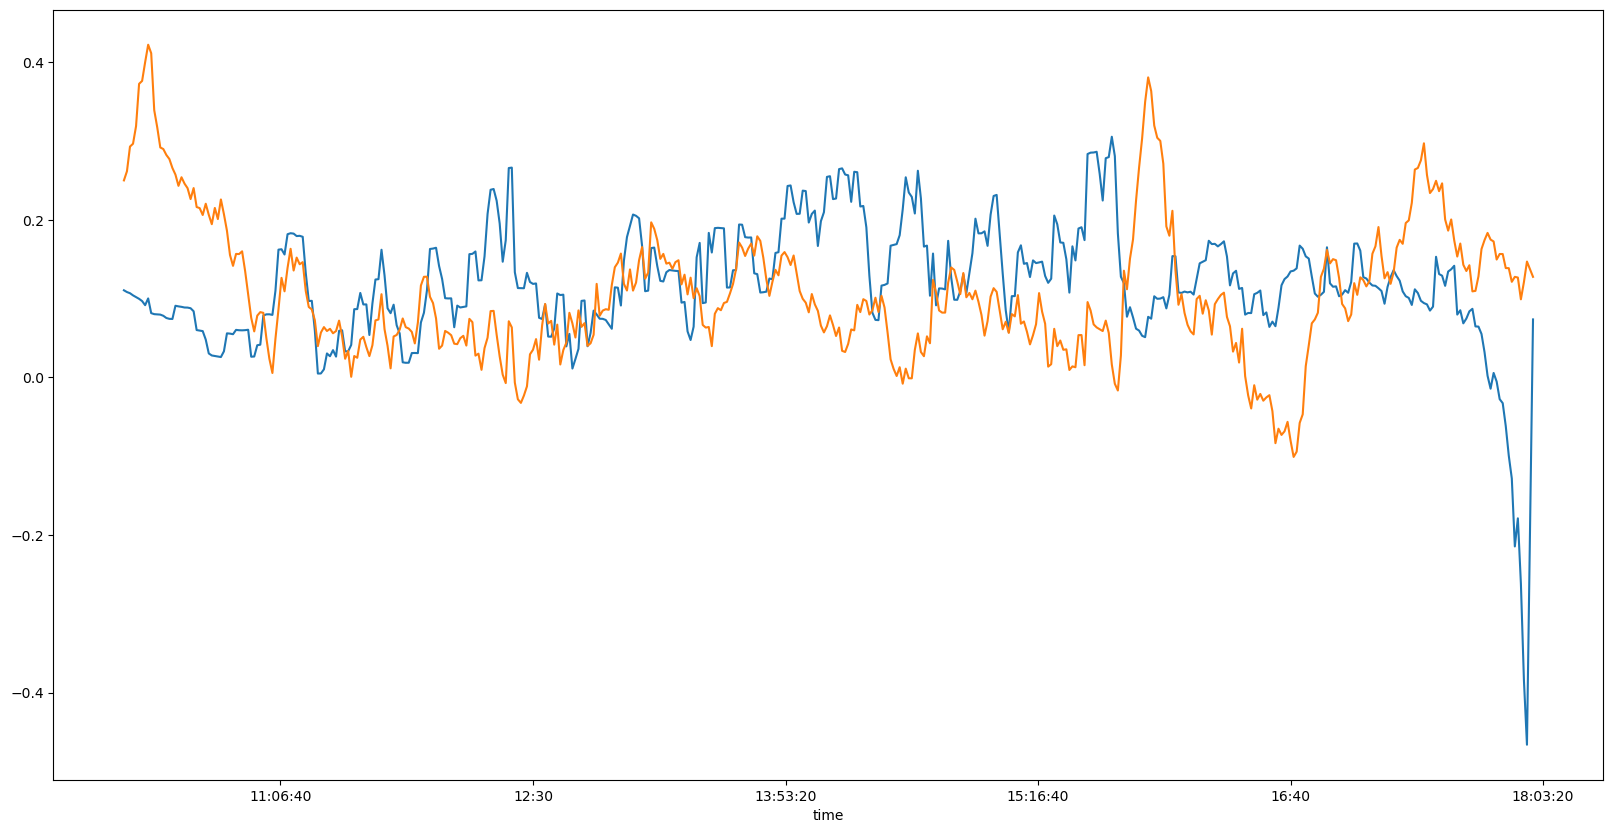

In [24]:
y_p2.groupby(y_p2.index.time).mean().plot(figsize=(20,10))
int_vol_ols_preds=ols_int_vol_mod.predict(sm.add_constant(X_p2))
int_vol_ols_preds=pd.Series(int_vol_ols_preds,index=y_p2.index)
int_vol_ols_preds.groupby(y_p2.index.time).mean().plot()

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.5, 'max_features': 0.5, 'max_depth': 35}


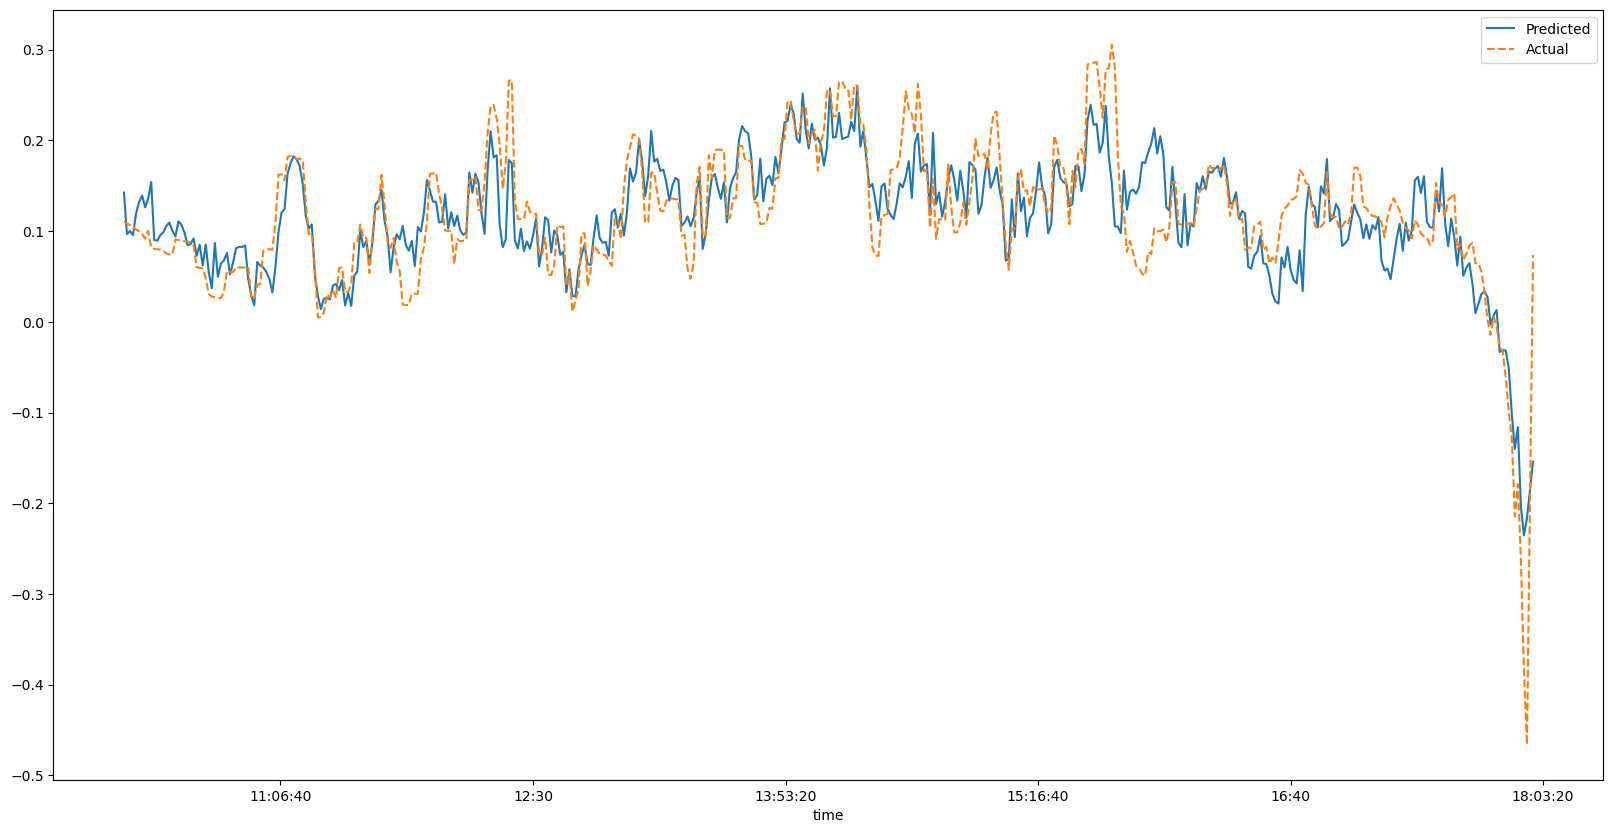

In [25]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load data
X = X_p2
y = y_p2

# Define the parameter grid
param_dist = {
    'n_estimators': [int(x) for x in np.linspace(start=20, stop=200, num=5)],
    'max_features': [0.5,1],
    'max_depth': [int(x) for x in np.linspace(10, 110, num=5)],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_samples': [0.5,1,2],
}

# Initialize the random forest model
rf = RandomForestRegressor(random_state=42)

# Initialize RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,
                               n_iter=20, cv=3, verbose=2, random_state=42, n_jobs=-1)

rf_random.fit(X, y)

print(f"Best Parameters: {rf_random.best_params_}")

# Use the best estimator from the random search
best_rf = rf_random.best_estimator_

# Make predictions
rf_predictions = best_rf.predict(X)
rf_preds_series = pd.Series(rf_predictions, index=y.index)

# Plot the predictions vs actual values
rf_preds_series.groupby(rf_preds_series.index.time).mean().plot(figsize=(20,10), label='Predicted')
y.groupby(y.index.time).mean().plot(style='--', figsize=(20,10), label='Actual')

plt.legend()
plt.show()


c:\Users\yusuf.bektas\AppData\Local\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='time'>

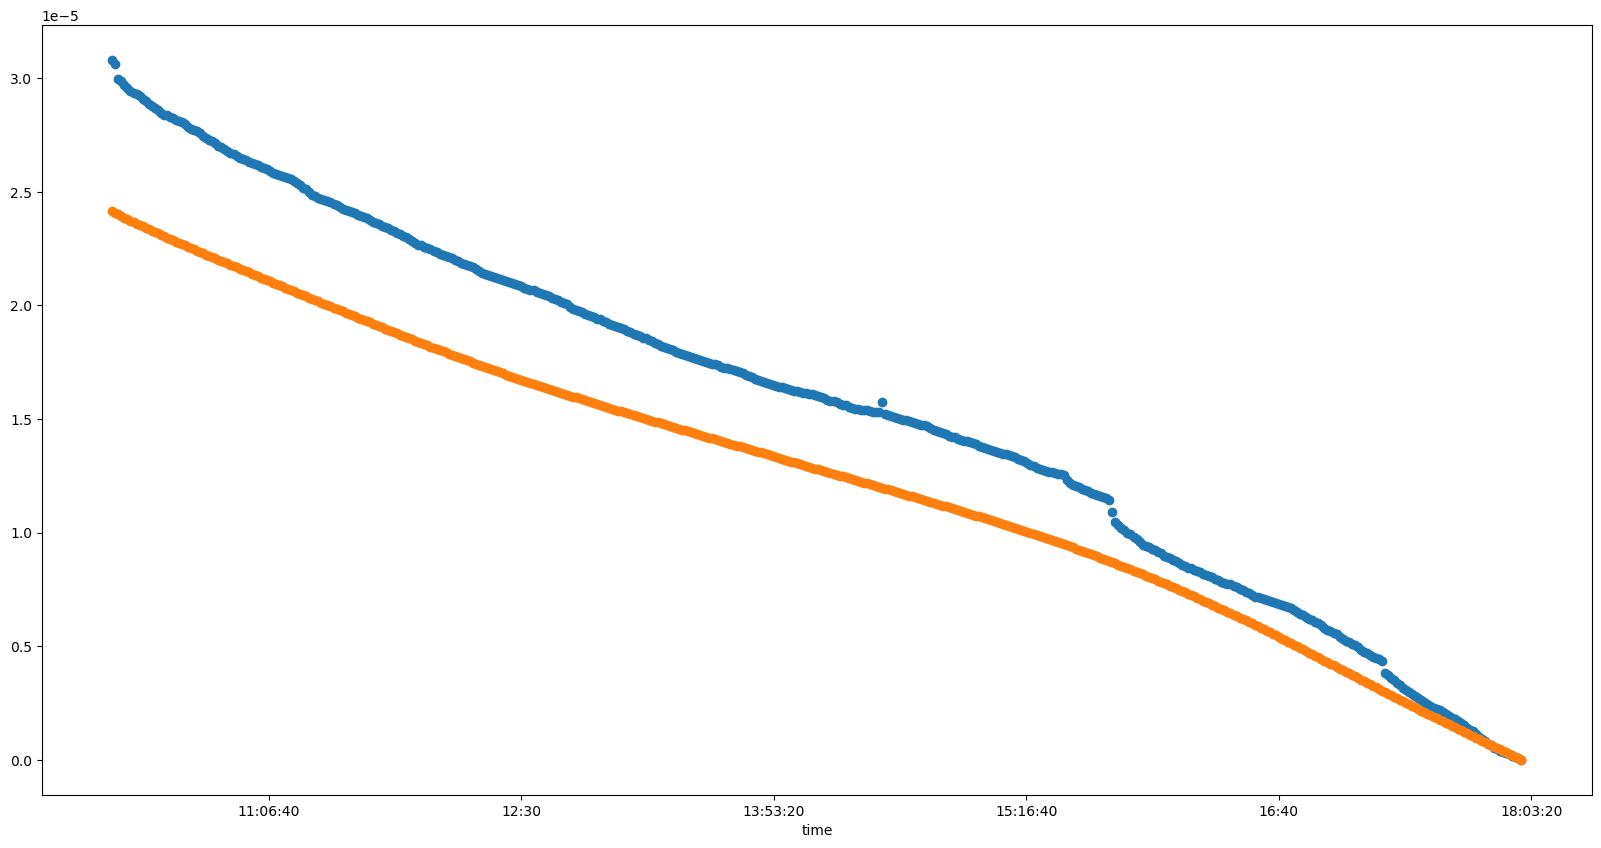

In [26]:

test_p2['vol']=0.5*(np.log(test_p2.high/test_p2.low)**2)-(2*np.log(2)-1)*(np.log(test_p2.close/test_p2.open)**2)
test_p2['volume_ret']=np.log(test_p2.volume/test_p2.volume.shift(1))

test_p2=test_p2.dropna().between_time("10:15","18:00")

test_p2['seasonal_vol']=pd.Series(test_p2.index.time,index=test_p2.index).map(seasonal_mlp_preds)
test_p2['seasonal_diff']=np.log(test_p2['vol']/test_p2['seasonal_vol'])
test_p2['seasonal_diff_avg']=test_p2['seasonal_diff'].rolling(avg_period).mean()    
test_p2['time_p']=test_p2.groupby(test_p2.index.normalize()).cumcount()/test_p2.groupby(test_p2.index.normalize()).cumcount().max()
cum_vol=test_p2.vol.groupby(test_p2.index.date).cumsum()
eod_cum_vol=cum_vol.groupby(test_p2.index.date).last()
test_p2['int_vol_eod']=test_p2.index.normalize().map(eod_cum_vol)-cum_vol
seasonal_cum_vol=test_p2.groupby(test_p2.index.date).seasonal_vol.cumsum()
eod_seasonal_cum_vol=seasonal_cum_vol.groupby(test_p2.index.date).last()
test_p2['int_seasonal_eod']=test_p2.index.normalize().map(eod_seasonal_cum_vol)-seasonal_cum_vol
test_p2['int_vol_eod'].groupby(test_p2.index.time).mean().plot(figsize=(20,10),style="o")
test_p2=test_p2.dropna()
test_p2['int_seasonal_eod'].groupby(test_p2.index.time).mean().plot(figsize=(20,10),style="o")

<Axes: xlabel='time'>

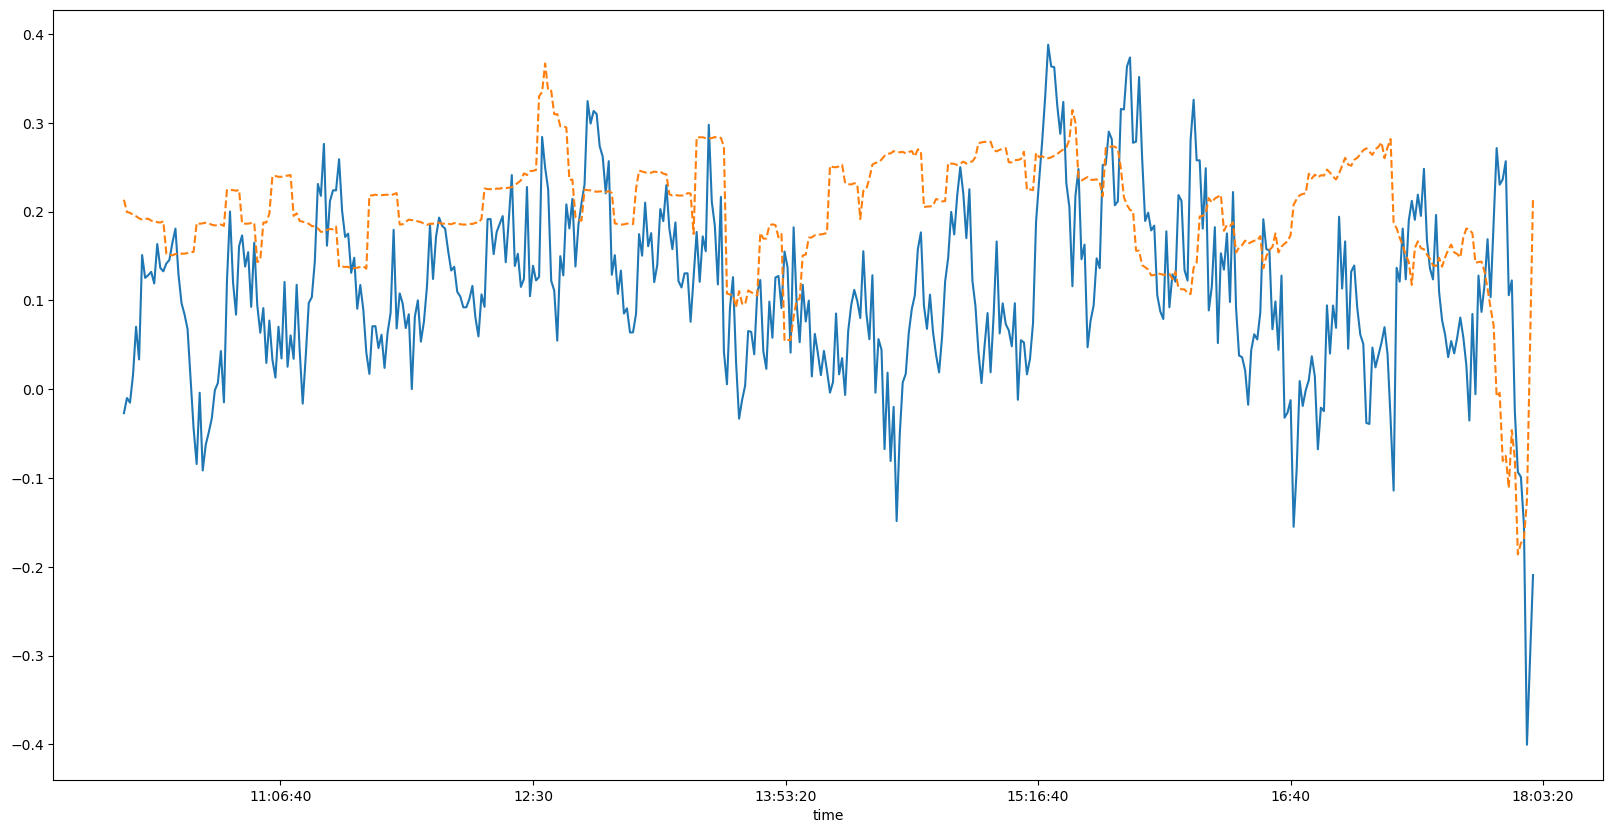

In [27]:
X_test=test_p2[['volume_ret','seasonal_diff','seasonal_diff_avg','time_p']].replace([np.inf,-np.inf],np.nan).dropna()
y_test=np.log(test_p2.int_vol_eod/test_p2.int_seasonal_eod).shift(-1).replace([np.inf,-np.inf],np.nan).dropna()
common_index=X_test.index.intersection(y_test.index)
X_test=X_test.loc[common_index]
y_test=y_test.loc[common_index]

rf_test_predictions = best_rf.predict(X_test)
rf_test_preds = pd.Series(rf_test_predictions, index=y_test.index)

# Plot the predictions vs actual values
rf_test_preds.groupby(rf_test_preds.index.time).mean().plot(figsize=(20,10), label='Predicted')
y_test.groupby(y_test.index.time).mean().plot(style='--', figsize=(20,10), label='Actual')


<Axes: xlabel='time'>

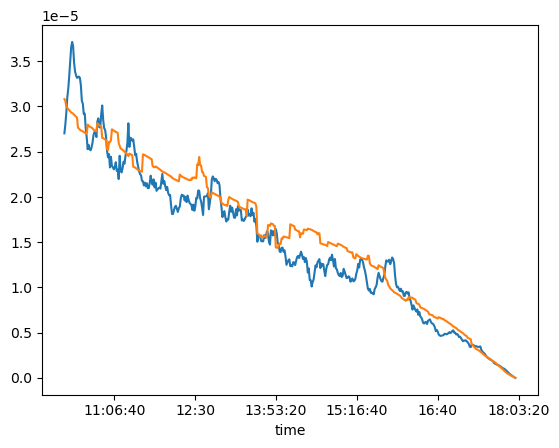

In [28]:
int_vol_ols_preds=np.exp(ols_int_vol_mod.predict(sm.add_constant(X_test)))*test_p2.int_seasonal_eod
int_vol_ols_preds=pd.Series(int_vol_ols_preds,index=y_test.index)
int_vol_ols_preds.groupby(y_test.index.time).mean().plot()
test_p2.int_vol_eod.groupby(test_p2.index.time).mean().plot()


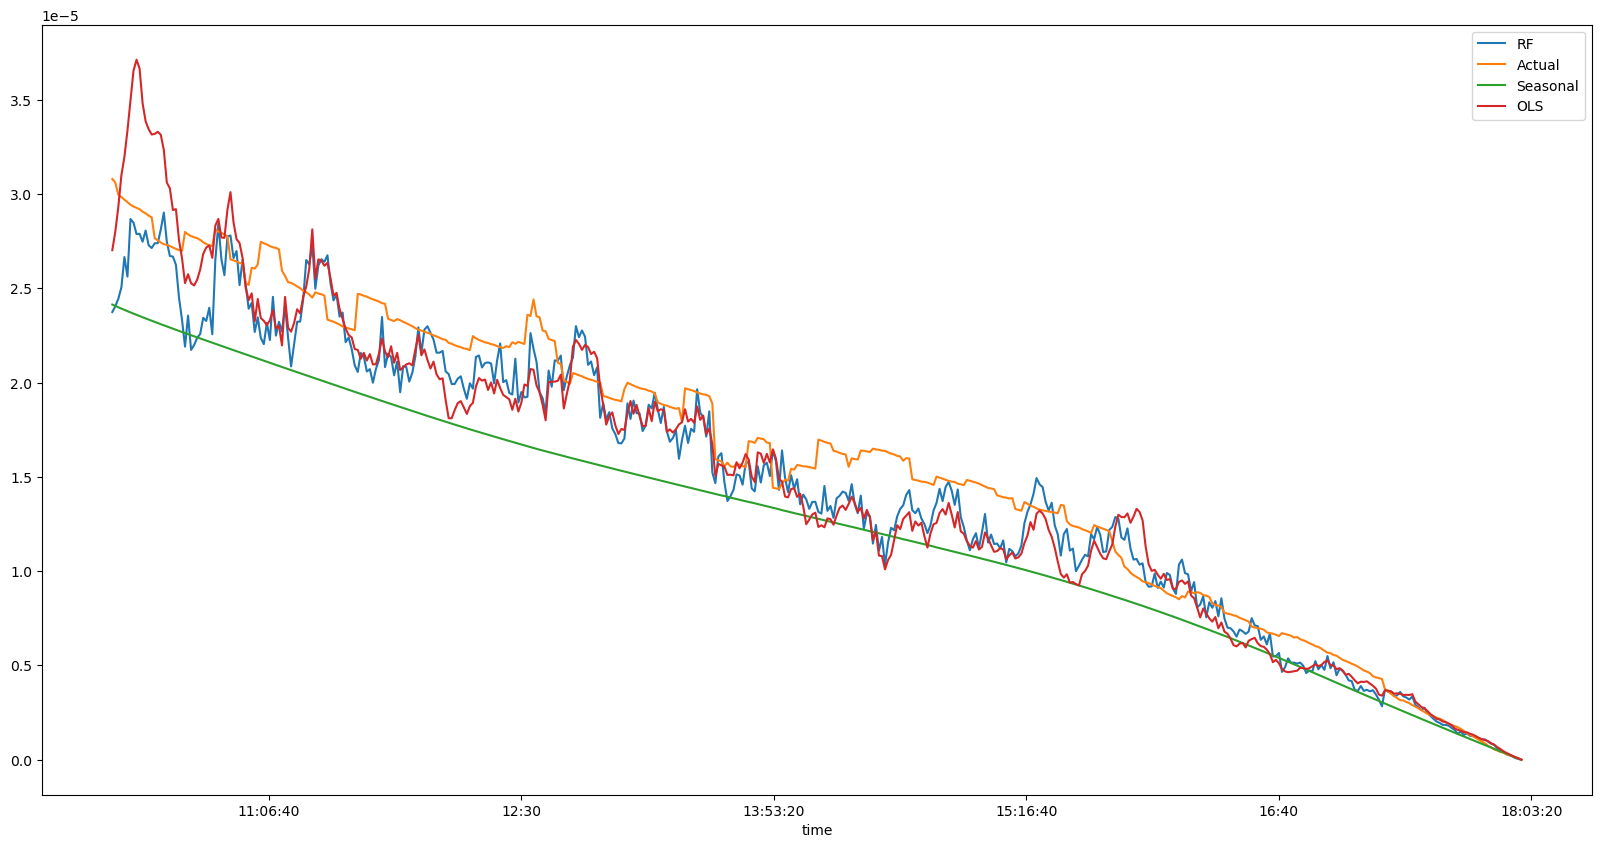

In [30]:
int_vol_test_rf_preds=(np.exp(rf_test_preds)*test_p2.int_seasonal_eod).dropna()

"""int_vol_test_mlp_preds=mlp_int_vol_mod.predict(scaler_X.transform(X_test))
int_vol_test_mlp_preds=scaler_y.inverse_transform(int_vol_test_mlp_preds)
int_vol_test_mlp_preds=pd.Series(int_vol_test_mlp_preds.flatten(),index=y_test.index)
int_vol_test_mlp_preds=np.exp(int_vol_test_mlp_preds)*test_p2.int_seasonal_eod
"""
fig, ax = plt.subplots(figsize=(20,10))
int_vol_test_rf_preds.groupby(int_vol_test_rf_preds.index.time).mean().plot(label='RF')
test_p2.int_vol_eod.groupby(test_p2.int_vol_eod.index.time).mean().plot(label='Actual')
test_p2.int_seasonal_eod.groupby(test_p2.int_seasonal_eod.index.time).mean().plot(label='Seasonal')
int_vol_ols_preds.groupby(int_vol_ols_preds.index.time).mean().plot(label='OLS')
#int_vol_test_mlp_preds.groupby(int_vol_test_mlp_preds.index.time).mean().plot(label='MLP')
ax.legend()

125/125 [==============================] - 0s 1ms/step


<Axes: xlabel='time'>

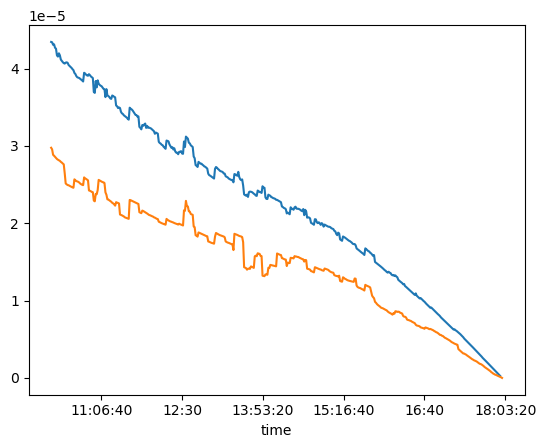

In [117]:
mlp_int_vol_test_preds=mlp_int_vol_mod.predict(scaler_X.transform(X_test))
mlp_int_vol_test_preds=pd.Series(mlp_int_vol_test_preds.flatten(),index=y_test.index)
mlp_int_vol_test_preds=np.exp(mlp_int_vol_test_preds)*test_p2.int_seasonal_eod.dropna()
mlp_int_vol_test_preds.groupby(mlp_int_vol_test_preds.index.time).mean().plot()
test_p2.int_vol_eod.groupby(test_p2.int_vol_eod.index.time).mean().plot()

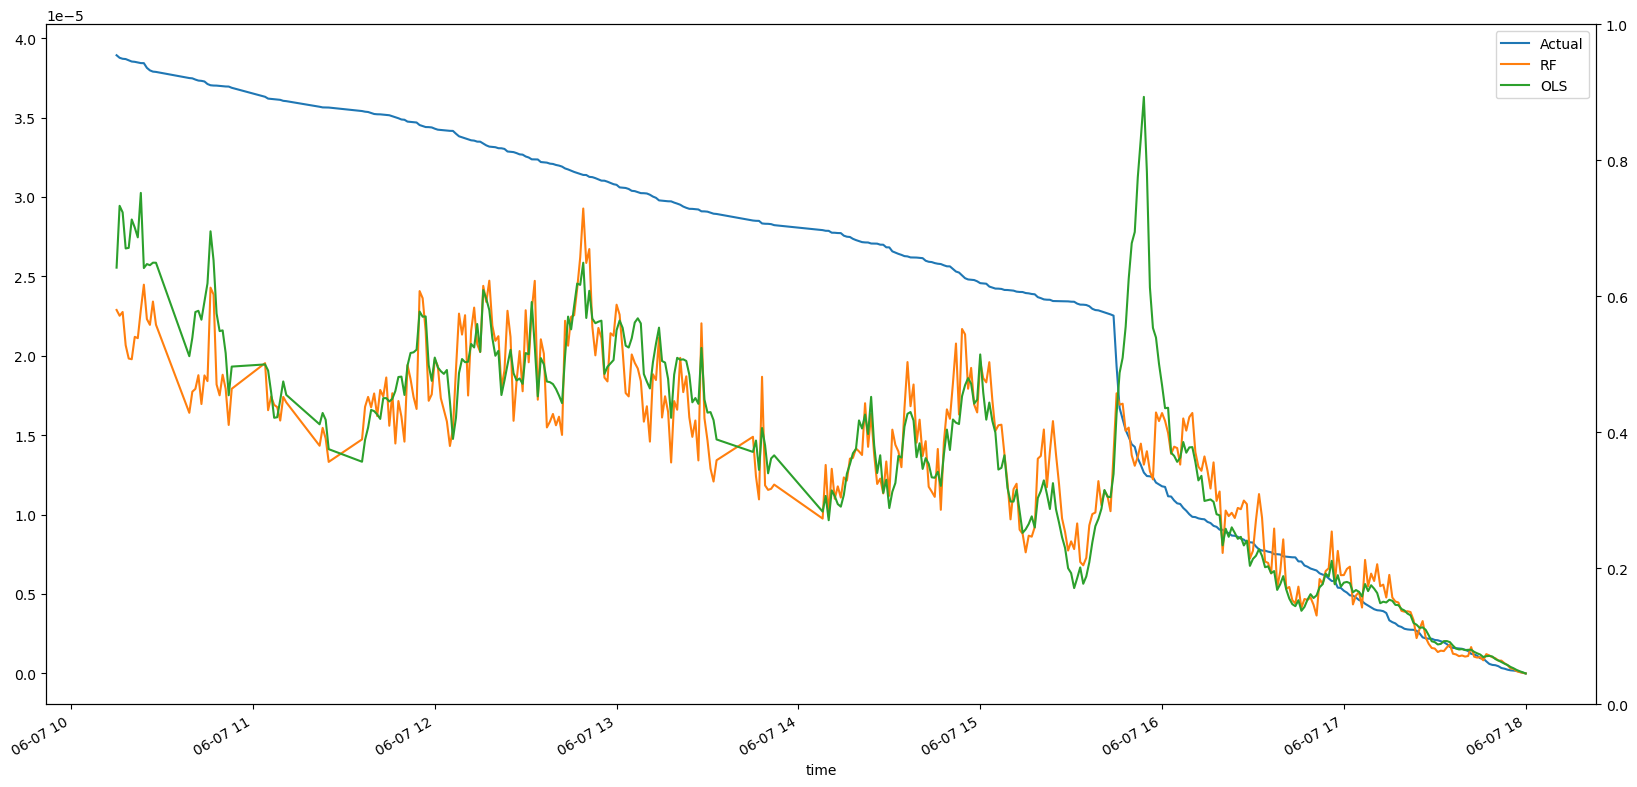

In [35]:
fig,ax=plt.subplots(figsize=(20,10))
day='2024-06-07'
actual=test_p2.int_vol_eod.loc[day]
#test_p2.int_seasonal_eod.loc[day].plot(label='Seasonal')
rf_d=int_vol_test_rf_preds.loc[day]
ols_d=int_vol_ols_preds.loc[day]
#mlp_d=int_vol_test_mlp_preds.loc[day]

common_index=actual.index.intersection(rf_d.index)
common_index=common_index.intersection(ols_d.index)
#common_index=common_index.intersection(mlp_d.index)

rf_d=rf_d.loc[common_index]
ols_d=ols_d.loc[common_index]
#mlp_d=mlp_d.loc[common_index]
actual=actual.loc[common_index]

mse_ols=mean_squared_error(actual,ols_d)*100000*100
mse_rf=mean_squared_error(actual,rf_d)*100000*100
#mse_mlp=mean_squared_error(actual,mlp_d)*100000*100
ax2=ax.twinx()
#ax2.set_title(f"rf:{mse_rf:.10f} ols:{mse_ols:.10f} mlp:{mse_mlp:.10f}")

actual.plot(ax=ax,label='Actual')
rf_d.plot(ax=ax,label='RF')
ols_d.plot(ax=ax,label='OLS')
#int_vol_test_mlp_preds.loc[day].plot(ax=ax,label='MLP')
ax.legend()

<Axes: xlabel='time'>

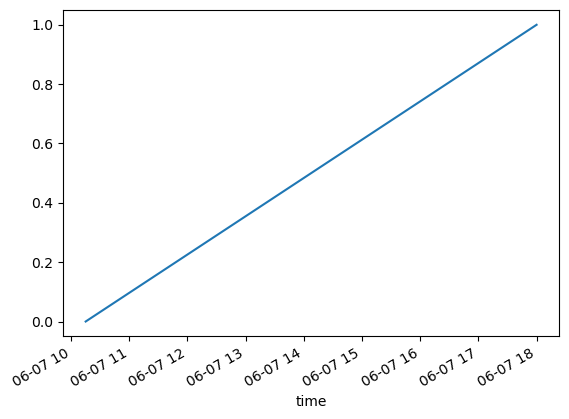

In [36]:
test_p2.loc[day,"time_p"].plot()

In [38]:
from sklearn.metrics import mean_squared_error
actual=test_p2.loc[y_test.index,'int_vol_eod']
print("RF MSE:",mean_squared_error(actual,int_vol_test_rf_preds))
print("OLS MSE:",mean_squared_error(actual,int_vol_ols_preds))
#print("MLP MSE:",mean_squared_error(actual,int_vol_test_mlp_preds.loc[actual.index]))



RF MSE: 3.301124829494432e-11
OLS MSE: 3.0672867626375924e-11


<Axes: xlabel='time'>

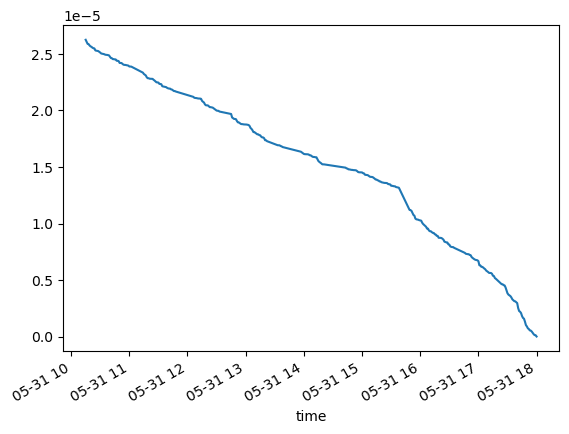

In [43]:
test_p2.loc["2024-05-31"].int_vol_eod.plot()

In [61]:
(test_p2.vol)*np.sqrt(252).

time
2024-05-27 17:55:00    4.450672e-09
2024-05-27 17:56:00    6.315425e-08
2024-05-27 17:57:00    1.956328e-08
2024-05-27 17:58:00    4.447152e-09
2024-05-27 17:59:00    4.447152e-09
                           ...     
2024-06-10 17:56:00    6.447392e-08
2024-06-10 17:57:00    6.447392e-08
2024-06-10 17:58:00    7.990409e-08
2024-06-10 17:59:00    4.089313e-08
2024-06-10 18:00:00    1.818563e-08
Name: vol, Length: 4028, dtype: float64

In [97]:
train_p2[train_p2.time_p<train_p2.time_p.shift()]

,open,high,low,close,volume,vwap,vol,volume_ret,seasonal_vol,int_vol_eod,int_seasonal_eod,seasonal_diff,seasonal_diff_avg,time_p
time,,,,,,,,,,,,,,
2024-04-16 10:15:00,4870.0,4870.0,4858.0,4863.0,5896.0,4863.521,2.244060e-06,1.703816,7.458831e-08,0.000068,0.000024,3.404058,1.188643,0.0
2024-04-17 10:15:00,4855.0,4860.0,4850.0,4859.0,6149.0,4853.969,1.859249e-06,1.244181,7.458831e-08,0.000057,0.000024,3.215944,0.834119,0.0
2024-04-18 10:15:00,4895.0,4896.0,4890.0,4892.0,4483.0,4892.159,6.066494e-07,1.298168,7.458831e-08,0.000040,0.000024,2.095967,0.814832,0.0
2024-04-19 10:15:00,4845.0,4851.0,4843.0,4850.0,4098.0,4846.446,9.511028e-07,1.487380,7.458831e-08,0.000064,0.000024,2.545638,0.291903,0.0
2024-04-22 10:15:00,4905.0,4909.0,4902.0,4909.0,5505.0,4905.231,7.614332e-07,0.749761,7.458831e-08,0.000039,0.000024,2.323219,0.270309,0.0
2024-04-23 10:15:00,4930.0,4932.0,4927.0,4932.0,3173.0,4928.566,4.508551e-07,0.893083,7.458831e-08,0.000035,0.000024,1.799162,NaN,0.0
2024-04-24 10:15:00,4995.0,4996.0,4988.0,4990.0,4708.0,4990.326,8.966505e-07,0.978849,7.458831e-08,0.000031,0.000024,2.486682,-0.476971,0.0
2024-04-25 10:15:00,4954.0,4957.0,4948.0,4949.0,3839.0,4952.822,1.257326e-06,1.103050,7.458831e-08,0.000044,0.000024,2.824759,0.926638,0.0
2024-04-26 10:15:00,4945.0,4948.0,4944.0,4945.0,3076.0,4945.832,3.270256e-07,0.919873,7.458831e-08,0.000032,0.000024,1.478055,0.588695,0.0


<Axes: xlabel='time'>

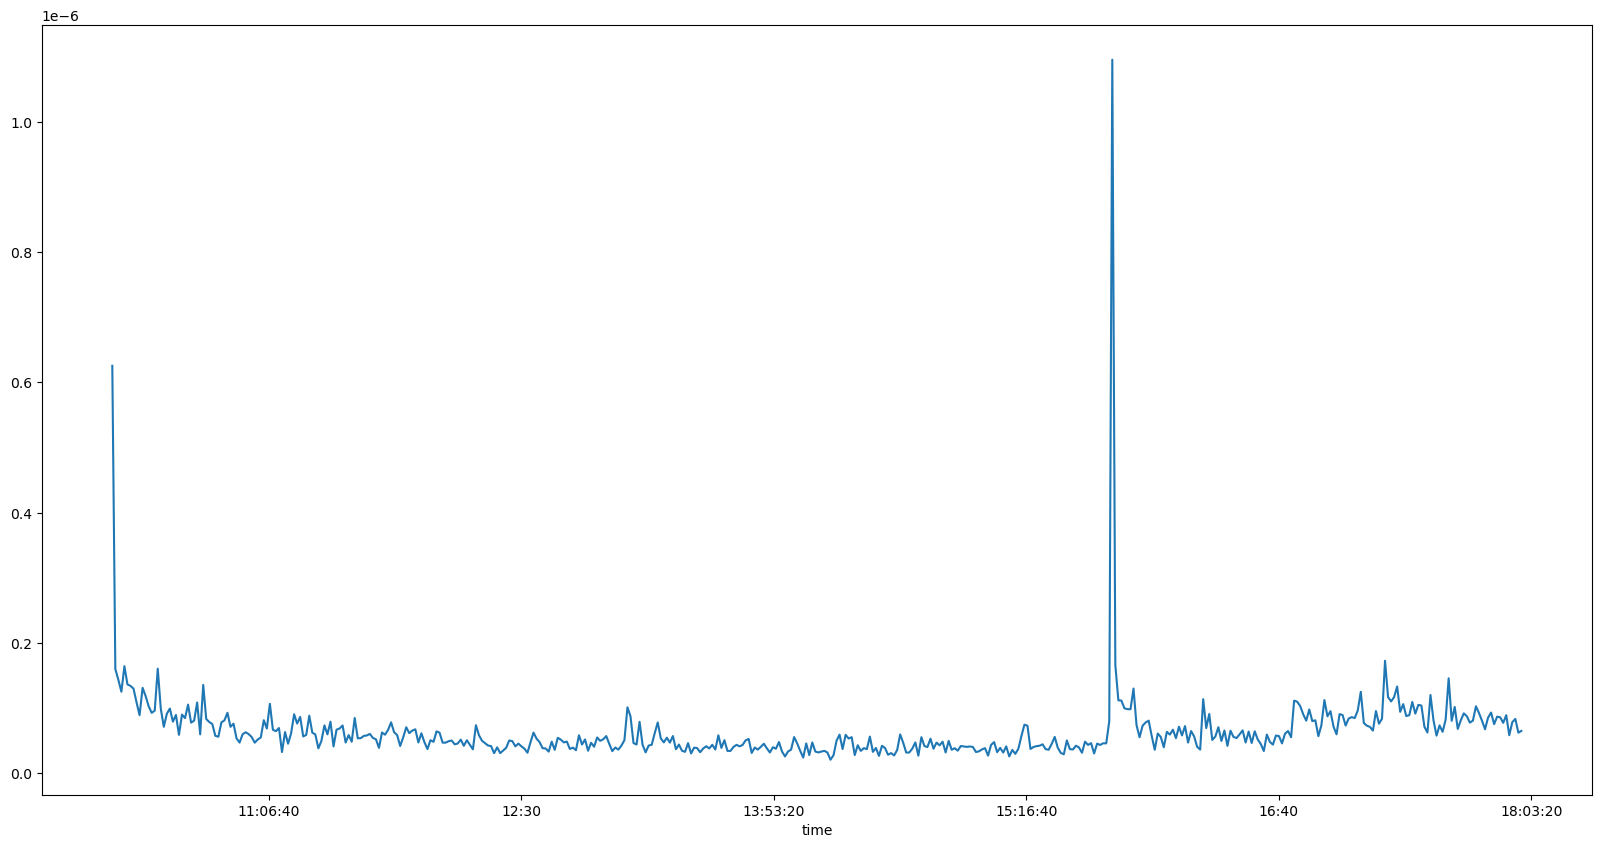

In [117]:

train_p2['vol'].groupby(train_p2.index.time).mean().plot(figsize=(20,10))

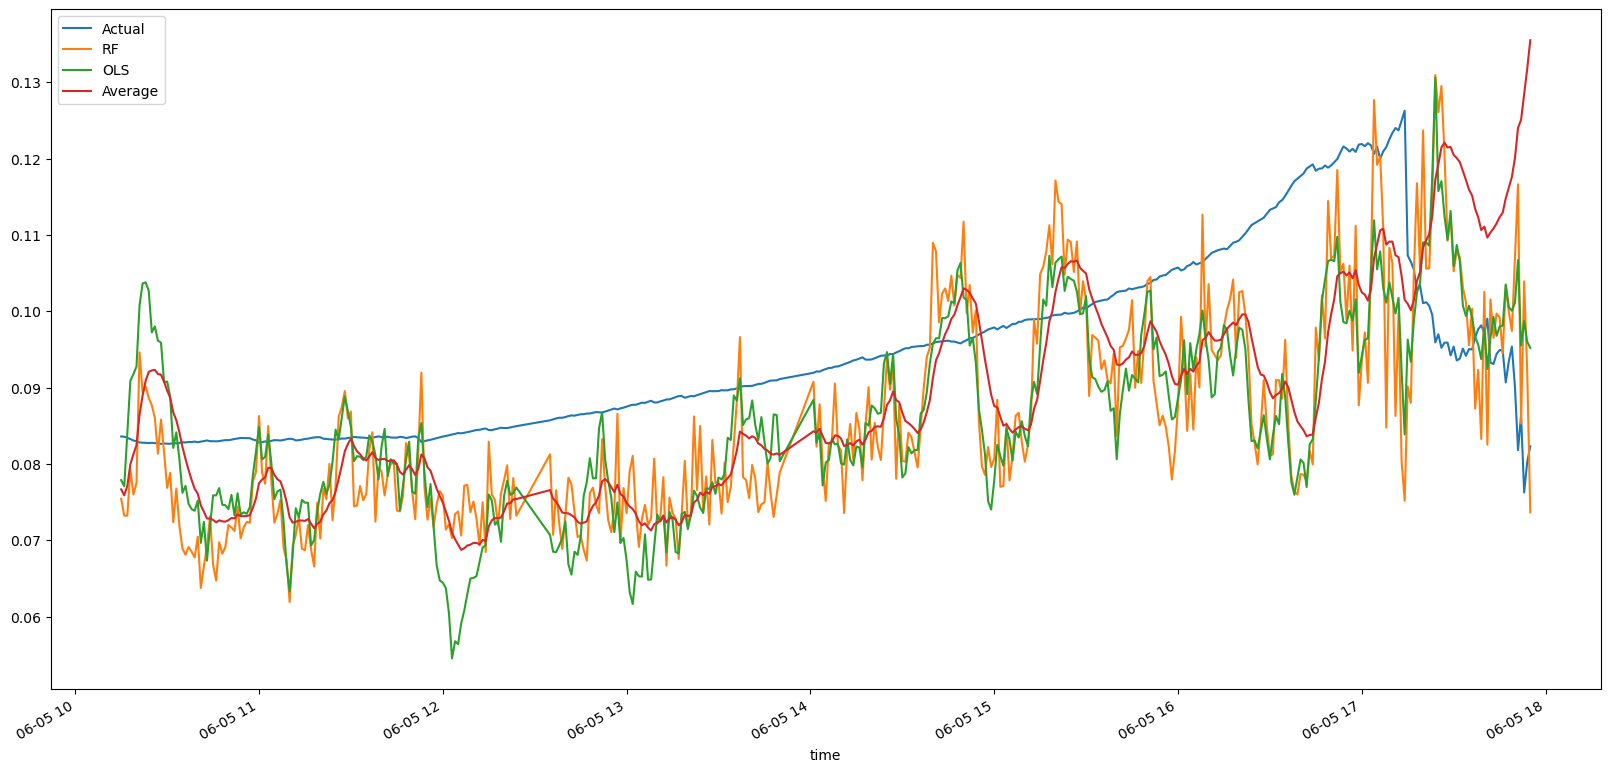

In [152]:
day="2024-06-05"
fig,ax=plt.subplots(figsize=(20,10))
d=test_p2.loc[day]
rf_d=int_vol_test_rf_preds.loc[day]
ols_d=int_vol_ols_preds.loc[day]
avg=((rf_d+ols_d)/2).ewm(span=10).mean()
np.sqrt(252*(d.int_vol_eod/(1-d.time_p))).between_time("10:15","17:55").plot(figsize=(20,10),label="Actual",ax=ax)
np.sqrt(252*(rf_d/(1-d.time_p))).between_time("10:15","17:55").plot(figsize=(20,10),label="RF",ax=ax)
np.sqrt(252*(ols_d/(1-d.time_p))).between_time("10:15","17:55").plot(figsize=(20,10),label="OLS",ax=ax)
np.sqrt(252*(avg/(1-d.time_p))).between_time("10:15","17:55").plot(figsize=(20,10),label="Average",ax=ax)
ax.legend()

#np.sqrt(d.vol*252*420).between_time("10:15","17:55").plot(figsize=(20,10),style="--",label="Volatility",ax=ax )

<Axes: xlabel='time'>

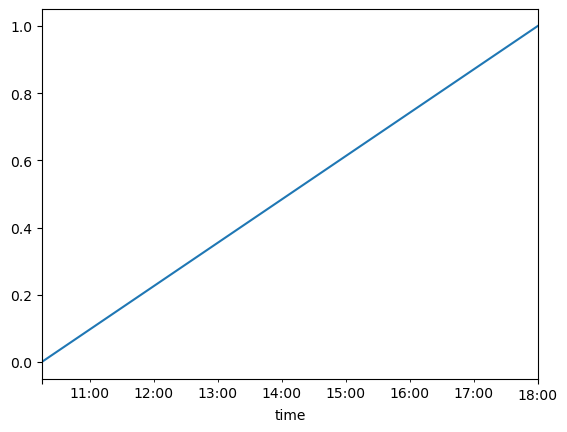

In [109]:

d.time_p.plot()

<Axes: xlabel='time'>

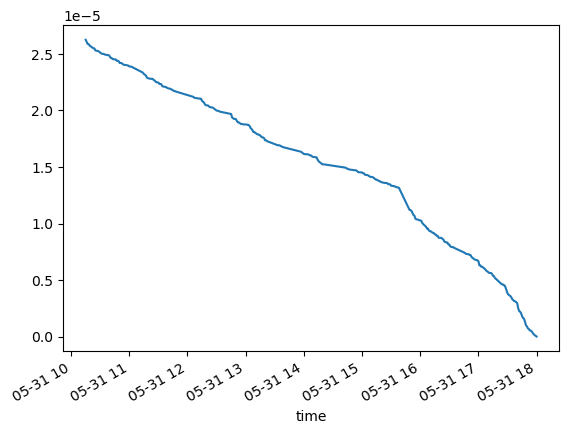

In [66]:
(actual/()).loc["2024-05-31"].plot()

<Axes: >

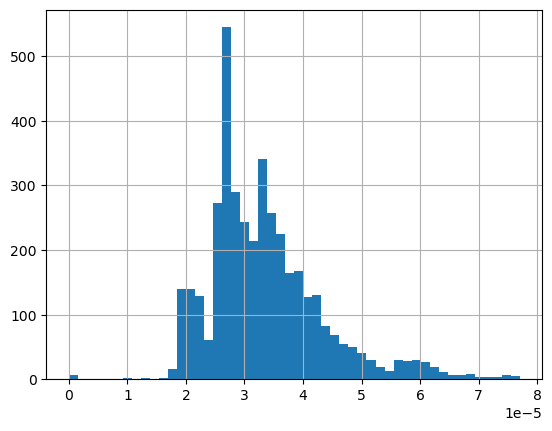

In [58]:
actual_ann=(actual)/(1-test_p2.time_p)
actual_ann=actual_ann.replace([np.infty,-np.infty],np.nan).dropna()
actual_ann.hist(bins=50)


<Axes: xlabel='time'>

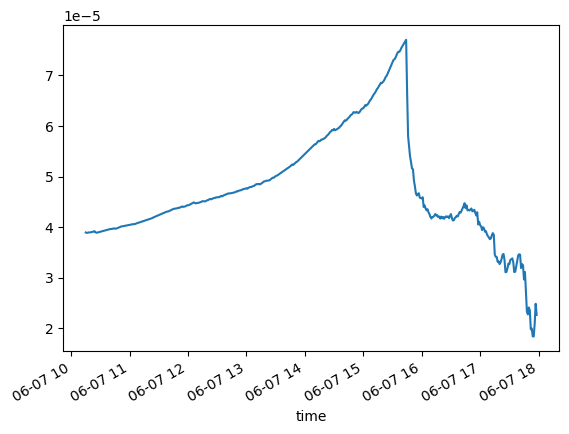

In [59]:
day='2024-06-07'
actual_ann.loc[day].plot()